### svm

利用SMO方法实现svm

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

---
#### 一些基本的辅助函数

In [2]:
def loadDataset(filename):
    dataMat=[]
    labelMat=[]
    fr=open(filename)
    for line in fr.readlines():
        #print(line)
        lineArr=line.strip().split('\t')
        dataMat.append([float(lineArr[0]),float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat

X_train,y_train=loadDataset('testSet.txt')

In [3]:
# 返回在0~m样本范围内,和i不同的随机的一个值
def selectJrand(i,m):
    j=i
    while(j==i):
        j=int(np.random.uniform(0,m))
    
    return j


In [4]:
# 把alpha clip到H和L范围内
def clipAlpha(aj,H,L):
    if aj>H:
        aj=H
    elif aj<L:
        aj=L
    return aj


In [5]:
# dataSe: 是数据集
# labels: 是标签,+1和-1
# C是 alpha的最大值,约束条件
# toler 误差容忍
# maxIter: alpha不再变化的最大迭代次数,尝试这么多次的迭代alpha都不在变化后,认为找到最优的alpha.
def smo(dataSet,labels,C,toler,maxIter):
    X=np.mat(dataSet)
    y=np.mat(labels).transpose()
    b=0
    m,n=X.shape
    #alphas=np.zeros([m,1],np.float32)
    alphas = np.mat(np.zeros((m,1),np.float32))
    #print(alphas)
    iterI=0
    
    #debug
    DEBUG_SVM=False
    if DEBUG_SVM == True:
        #print("X.shape:%s,y.shape:%s"%(X.shape,y.shape))
        #print("X:%s,y:%s"%(X,y))
        print(maxIter)
        
    while(iterI<maxIter):# end
        # update
        alphaPairsChanged=0
        for i in range(m):# end
            fXi=float(np.multiply(alphas,y).T*(X*X[i,:].T))+b
            print("fXi:%s" %fXi)
            print(alphas.shape)
            print(y.shape)
            print((np.multiply(alphas,y).T).shape)
            print(X.shape)
            print(X[i,:].shape)
            
            Ei=fXi-float(y[i])
            
            if DEBUG_SVM == True:
                #print("alpha:%s",alphas)
                print("[i:%d] fXi:%s,y[%d]:%s,Ei:%s" %(i,fXi,i,y[i],Ei))

            
            # KKT conditions
            # 第一: 偏差大于 toler. y[i]表符号.
            # 第二: alphas[i]满足0~C,而且不能取边界; 这个边界问题我还没搞懂
            if ((y[i]*Ei<-toler) and alphas[i]<C ) or ((y[i]*Ei>toler)and alphas[i]>0): #kkt条件,参考<<支持向量机通俗导论>>及<<支持向量机导论>>
                j=selectJrand(i,m)
                fXj=float(np.multiply(alphas,y).T*(X*X[j,:].T))+b
                
                Ej=fXj-y[j]

                if DEBUG_SVM == True:
                    print("[j:%d] fXj:%s,y[%d]:%s,Ej:%s" %(j,fXj,j,y[j],Ej))
                
                alpha_i_old=alphas[i].copy()
                alpha_j_old=alphas[j].copy()
                if y[i]!=y[j]:
                    L=max(0,alphas[j]-alphas[i])
                    H=min(C,C+alphas[j]-alphas[i])
                else:
                    L=max(0,alphas[i]+alphas[j]-C)
                    H=min(C,alphas[j]+alphas[i]) #### 2018-08-15debug issue:   这部分的逻辑出现问题了.注意同号时候要相加.
                if L==H: #### 2018-08-15debug issue:   这部分丢掉了L和H相等的时候,是alphas[i]和alphas[j]同为0时,此时后面没必要再去计算,更新量都为0.
                    print("L==H")
                    continue
                eta=2.0*X[i,:]*X[j,:].T - X[i,:]*X[i,:].T - X[j,:]*X[j,:].T
                if DEBUG_SVM == True:
                    print("eta:%s"%eta)
                    print("i:%d,X[i,:]:%s" %(i,X[i,:]))
                    print("j:%d,X[j,:]:%s" %(j,X[j,:]))
                    print("X[%d,:]*X[%d,:].T:%s"%(i,j,X[i,:]*X[j,:].T ))
                    print("X[%d,:]*X[%d,:].T:%s"%(i,i,X[i,:]*X[i,:].T ))
                    print("X[%d,:]*X[%d,:].T:%s"%(j,j,X[j,:]*X[j,:].T ))
                    
                if eta>=0:
                    print("eta >=0")
                    continue
                alphas[j]-=y[j]*(Ei-Ej)/eta # 更新alpha[j]
                alphas[j]=clipAlpha(alphas[j],H,L)
                if DEBUG_SVM == True:
                    print("Ei-Ej:%s"%(Ei-Ej))
                    print("L:%s,H:%s"%(L,H))
                    print("(Ei-Ej)/eta:%s" %((Ei-Ej)/eta))
                    print("alphas[%d]:%d"%(j,alphas[j]))

                if(np.abs(alphas[j]-alpha_j_old)<0.00001):
                    print("j not move")
                    continue
                alphas[i]+=y[j]*y[i]*(alpha_j_old-alphas[j])
                
                b1=b-Ei-y[i]*(alphas[i]-alpha_i_old)*X[i,:]*X[i,:].T-y[j]*(alphas[j]-alpha_j_old)*X[j,:]*X[j,:].T
                b2=b-Ej-y[i]*(alphas[i]-alpha_i_old)*X[i,:]*X[i,:].T-y[j]*(alphas[j]-alpha_j_old)*X[j,:]*X[j,:].T
                if (0<alphas[i]) and (C>alphas[i]):
                    b=b1
                elif (0<alphas[j]) and (C>alphas[j]):
                    b=b2
                else:
                    b=(b1+b2)/2.0
                    
                alphaPairsChanged+=1
                print("iter: %d i:%d, pairs changed %d" % (iterI,i,alphaPairsChanged))
        #if DEBUG_SVM==True:
        #    break
            
        if alphaPairsChanged==0:
            iterI+=1
        else:
            iterI=0
        print("iteration num: %d"%iterI)
    
    return b,alphas
                
                
            
        # break
    
b,alphas=smo(X_train,y_train,0.6,0.001,40)    

fXi:0.0
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:0.0
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 0 i:1, pairs changed 1
fXi:[[-0.52020438]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:[[-1.89048724]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.38873481]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:[[-0.78774121]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 0 i:5, pairs changed 2
fXi:[[ 0.03425733]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:[[-1.78379327]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.78308394]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.15190321]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.48392631]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.50059254]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.28396057]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 0.97478055]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.51784829]]
(100, 1)
(100, 1)
(1, 

(1, 2)
fXi:[[ 3.21103957]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 0.33106118]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.70683799]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.02674897]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.51816932]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-0.43393728]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.72941597]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 0.26120852]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:[[-0.0127744]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.56430149]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.42648118]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.26701593]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.70682604]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 0.30792281]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:[[ 0.05676908]]
(100, 1)
(100, 1)
(1, 100)


(1, 2)
fXi:[[ 1.0664252]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.87617188]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.79499896]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.34098845]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.02377234]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.90429039]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.44244684]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.58461795]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:[[ 1.69416532]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.76918086]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.55494487]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.19157804]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.95746984]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.54660131]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.1396292]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.81619606]]
(10

(1, 2)
fXi:[[-1.26853037]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.66027518]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.88707158]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:[[ 1.73344299]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.88938137]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.59617622]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.34544966]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.0807441]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.53505741]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.26398716]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.20889974]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.2770648]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.33223118]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.29129173]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.25091307]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.52307531]]
(100, 1)
(100, 1)
(1, 100

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.80798883]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 0
fXi:[[-1.18367323]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.61300623]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.93535351]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.67015183]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.736662]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.5524294]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.88203537]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.59359364]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.0806436]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.57658768]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.1131714]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.51545882]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.879033]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.82940192]]
(100, 1)
(100, 1)
(1, 100)
(100,

(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.89044755]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.51505904]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 0 i:24, pairs changed 1
fXi:[[ 1.66172516]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.46623468]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.86349355]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.66807605]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.17002252]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.48645957]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.8014479]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.48764542]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.50894564]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.83890405]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.12940747]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.25915366]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.13232155]]
(100, 1)
(1

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.47932939]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.07390114]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.92713465]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 2 i:52, pairs changed 2
fXi:[[-1.98752359]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 0.78756202]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 0.65704047]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 2 i:55, pairs changed 3
fXi:[[-1.94109358]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.30590586]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.44116498]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.6219117]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.96695338]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.21224419]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.14938623]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.05377954]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(

fXi:[[-1.27984471]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.43401181]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.60272412]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.22233982]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.27134325]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.89281154]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.17438769]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.17219517]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.69428004]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.79764375]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.88175681]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.81860258]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.11390782]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.13836592]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.57996421]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.97334314]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)

(1, 2)
fXi:[[ 2.15824052]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.98474385]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.32851955]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.29282308]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.65044065]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.57820531]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.64683644]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.15302018]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.57615697]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.4019949]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.37708845]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.33984134]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.91044603]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.33087089]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 2 i:17, pairs changed 1
fXi:[[ 2.63235308]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2

(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.93009336]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.62837719]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.6876389]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.98356216]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.07105833]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.44334123]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.05031811]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.25565311]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.83298587]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.54945851]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.55126795]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.62179949]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.28263465]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.48453596]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.89460581]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.51505368]]
(100, 1)
(1

(1, 2)
fXi:[[-2.95829127]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.11574001]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.31516439]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.69382282]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.9156636]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.47003606]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.6625689]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01129264]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.19679591]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.33834911]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.5308335]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.18475088]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.5665465]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.44570748]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.46785328]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.5145978]]
(100, 1)
(100, 1)
(1, 

(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.22145152]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.11144576]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.88972604]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.41326056]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.676115]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.74799211]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.60347937]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.55520122]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.40973255]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.82491383]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.41719058]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.35887009]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.43720793]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.13765324]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 0
fXi:[[-1.32973307]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.855963

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.08603861]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.48951592]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.9702591]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.78905648]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.35781812]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.76291281]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.0938282]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.96729033]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.34544474]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.04508247]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.30805594]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.09814544]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.92588608]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.7613446]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.71623534]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.9630

(1, 2)
fXi:[[-2.34465006]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.86102257]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.75188804]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.84161777]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.15388827]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.77851352]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.56378772]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.85025768]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.33534888]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.04606713]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.40187475]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.07030507]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.98770562]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 0.92906271]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 0.95890786]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.31391679]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.62297693]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.55492355]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.60947788]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.37838662]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.27600662]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.58502955]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.74558458]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.50464362]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.31344385]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.13647587]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.24228459]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.78420901]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.3657753]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.24863039]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.91

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.16190859]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.2575261]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01040936]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 2
fXi:[[-1.23695598]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.78078498]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.70482431]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.81643085]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.41712298]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.21871252]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.58777792]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.72464975]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.10494715]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.93516987]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.12552111]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.61253865]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(

j not move
fXi:[[-1.92692366]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.09211539]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.57558139]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.73331774]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.97371231]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.32262974]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.14585468]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.11425098]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.87466051]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.6711181]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.83948643]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.54477298]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.73602202]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.43022524]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.13760781]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.65434205]]
(100, 1)
(100,

(1, 2)
fXi:[[ 3.05205242]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.50912724]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.8102726]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.73903233]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.18535065]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.08259448]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.92692363]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.09211557]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.57558137]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.73331771]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.97371228]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.32262971]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.14585484]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.11425098]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.87466051]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(

fXi:[[-1.46344416]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.54372286]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.51536634]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.24638916]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.32639353]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.90434748]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.35023749]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.28501306]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.74294988]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.88167195]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.99628885]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.90748932]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.0621427]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.21739528]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.70353746]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.92095127]]
(100, 1)
(100, 1)
(1, 100

(100, 2)
(1, 2)
fXi:[[-2.00955031]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.16333055]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.01117417]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.31732583]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.92385592]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.33823931]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.10135904]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.33029764]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.79200181]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.17436812]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.39894515]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.99653441]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.33231448]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.85955572]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.05028443]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[

(1, 2)
j not move
fXi:[[-1.33037734]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.17046288]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.89377991]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.79158313]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.15902963]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.96951348]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.49546684]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.05120119]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.21577402]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.20060505]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.54284311]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.42516238]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.72064272]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.99347839]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.69103626]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.05142132]]
(100, 1)
(100, 1)

(100, 2)
(1, 2)
j not move
fXi:[[-2.15191454]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.87850071]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.77284257]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.93326838]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.19507445]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.52529584]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.89837201]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.32617306]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.62384159]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.88880508]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.04589339]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.2842191]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.47744385]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.18399859]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.29054361]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.39728783]

(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.24850227]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 3.24893013]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.83833324]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.96055004]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.06077269]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.9843065]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.11584665]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.30949742]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.67396791]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.97069581]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.59303484]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.40723404]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.35104147]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.77732839]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.40894382]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.22075162]]


fXi:[[-1.80921742]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.22936014]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.0005041]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.2008042]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.65908181]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.022671]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.66152161]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.86277937]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.55123908]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.10466968]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.95923776]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.34351833]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.65625931]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.94428298]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.84345237]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.42085786]]
(100, 1)
(100, 1)
(1, 100)
(

(1, 2)
fXi:[[ 2.9631275]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.31133978]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.97525611]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.65287809]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.06614223]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.23438714]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.36601656]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.57562545]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.44638118]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.803588]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.98883138]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.86500666]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.19860639]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.80683582]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.54729031]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.92495475]]
(100, 1)
(100, 1)
(1

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.29230172]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.46256388]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.85386741]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.9340403]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.62236712]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.71038239]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.14604173]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.33745561]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.37188613]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.57233657]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.17405196]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.71483537]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.48400884]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.5442517]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.66733186]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.516

fXi:[[-2.19880517]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.3417603]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.22963267]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.09165219]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.55316283]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.89479266]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.94076196]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.7552813]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.69771355]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.4943448]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.93649868]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.50920765]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.42942572]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.58256035]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.27595457]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 1
fXi:[[-1.42336531]]
(100, 1)
(100, 1)
(1,

(100, 2)
(1, 2)
fXi:[[-2.48088693]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.53525214]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.18942962]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.64427438]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.16448971]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.86715529]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.49403515]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.92384417]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.20784932]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.07709769]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.49325981]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.09250746]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.40279649]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.23753218]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.05051255]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.85266748

fXi:[[ 2.55620957]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.106828]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.0870609]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.02264056]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.02264058]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.1800299]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.94738349]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.97265805]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.12505256]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.24417013]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.68670089]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.14810621]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.43058398]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.91966058]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.94547454]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.168676

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.29633704]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.46881953]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.65821325]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.25504767]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.8323712]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.56724331]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.66735468]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.63323167]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.51285016]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.66516032]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.95031164]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.49951184]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.33559621]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.12593752]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.29261236]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.81537242]]
(1

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.86831931]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.44338713]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.37224084]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.50889021]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.20076026]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 2
fXi:[[-1.35546625]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.91137375]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.70232892]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.06351553]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.52168247]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.20878449]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.73860274]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.95333878]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.2252586]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.29978066]]
(100, 1)
(100, 1)
(1, 100)
(

(1, 2)
fXi:[[-1.07885777]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.38526964]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.20957049]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.02488779]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.82951901]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.87757521]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.99815507]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.35458259]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.46804453]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 3.25006206]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.00567349]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.40098997]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.00413239]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.65027945]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.17689866]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.3154368]]
(100, 1

(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.06098345]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.00986006]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.00985996]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.15279086]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.92304771]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.93551444]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.08600469]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.2161296]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.65313054]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.1212621]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.40021403]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.88317535]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.9211664]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.14157916]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.58580577]]
(100, 1)
(100, 1)
(1, 100)
(100, 2

fXi:[[ 2.83315284]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.27880161]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.24006287]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.99130991]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.13940714]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.26192713]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.16675961]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.98900646]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.48679066]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.67519179]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.84257891]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.57600285]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.60911169]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.48540017]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.91489039]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.51877266]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.86543453]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.32222113]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.48422359]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.09174033]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.49652087]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.02438365]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.96868406]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.32326211]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.84224146]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.13733391]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.02129078]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.35644303]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.05814096]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.44226181]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.12893801]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
f

fXi:[[-2.27345296]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.41722003]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.62344262]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.4663429]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.8796275]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.96986451]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.88084903]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.20086539]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.80821354]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.56894639]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.92895056]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.37091358]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.00307517]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.42539925]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.03773714]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.99874039]]
(100, 1)
(100, 

fXi:[[-2.09832613]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.46669003]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.66251215]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.30576182]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.44675298]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.57707129]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.60174227]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.4177422]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.26768657]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.66481061]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.71802007]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.47130447]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.4179145]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.15267372]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.27592159]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.8331532]]
(100, 1)
(100, 1)
(1, 100)


(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01306772]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.60019426]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.48903423]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.64532963]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.36244242]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 1
fXi:[[-1.52785963]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.09827063]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.61873896]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.1850281]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.36538016]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.1103017]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.56250008]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.08178144]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.39141784]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.397995]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.44071723

(100, 2)
(1, 2)
fXi:[[-1.14875012]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.51190794]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.13457477]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.94201183]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.90064498]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.95075279]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.0776225]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.43496649]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.37263303]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 3.15476373]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.96571047]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.32818607]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.10175319]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.62484046]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.23962229]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.39446959]

(1, 2)
fXi:[[ 2.44317698]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.14047483]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.12196074]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 0.97947713]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 0.92237707]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.2705083]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.92239572]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.00727606]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.16728058]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.32696009]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.7309499]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.04755553]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.49355959]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.81885505]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01700046]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.21653043

fXi:[[ 2.49421981]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 3.27012083]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.13342245]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.47089723]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.94596248]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.80865268]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.05066304]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.21923592]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.54818849]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.57384424]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.42782264]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.84835872]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.93936571]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.04374342]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.35290694]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.95016143]]
(100, 1)
(100, 1)
(1, 10

fXi:[[-2.31209999]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.97893586]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.63379103]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.77751088]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.82890337]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.64447711]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.77752005]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.58099188]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.02063232]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.59577024]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.51644184]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.66302144]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.35815856]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 0
fXi:[[-1.51041586]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.07213424]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.58646895]]
(100, 1)
(100, 1)


(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.84650778]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.43667659]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.74661284]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.04440206]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.92597613]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.46216579]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.96513065]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.33025681]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.2301239]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.04105496]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.69734788]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.69353483]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.8978447]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.2459042]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.45770091]]
(100, 1)
(100, 1)
(1, 100)
(100,

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.96522647]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.2963173]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.90307197]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.64631422]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.02540056]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.24425948]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.05949011]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.51048073]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.90602387]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.86890356]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.15929657]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 2 i:54, pairs changed 1
fXi:[[ 0.96231143]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.05535518]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.00119818]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.6875

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.41240172]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.38198943]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.40344216]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.23895696]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.4802859]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.70359356]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.2870068]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.29537357]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.00289791]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.08745798]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.66952631]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.07924641]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.03483526]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01111478]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.14453173]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.25452

(100, 2)
(1, 2)
fXi:[[-2.29102644]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 4
fXi:[[-1.51794254]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.07101583]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.48380263]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.07865588]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.16315779]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.98859581]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.32621023]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.9893595]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.38251934]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.19349387]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.38737812]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.86511038]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.27083249]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.36964224]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.0763114]]
(100

fXi:[[-1.79596291]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.72327798]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.03512071]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.37184699]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.18121015]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.91555327]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.81588248]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.17127074]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.02199035]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.51632726]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.10234761]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.27063056]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.2085481]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.60211794]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.48562801]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.79619864]]
(100, 1)
(100, 1)
(1, 100

fXi:[[ 0.83100579]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.20865284]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.89179164]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.83564813]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.99921955]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.25196202]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.58477769]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.9065754]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.38376744]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.64378796]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.93992103]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.09786132]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.29685897]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.49367009]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.18031368]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.33808858]]
(100, 1)
(100,

(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.0111148]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.14453175]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.25452329]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.16968505]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.84072083]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.48441876]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.45536121]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.69829064]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.38993088]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.59322662]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.52516198]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.94316165]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.56836097]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.41850112]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.52861338]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.29102632]]
(100, 1)
(1

fXi:[[-2.27083253]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.36964243]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.07631137]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.32862211]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.85512634]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.0746402]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.14453136]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.82774787]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.136367]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.02963503]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.19603473]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.08842691]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.50909833]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.98644695]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.79461022]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.79596291]]
(100, 1)
(100, 1

(1, 2)
fXi:[[-2.45431246]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.89355528]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.93731662]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.88654567]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.20201448]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.81086384]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.57969675]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.92737687]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.37479445]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.02492729]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.43201488]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.04851233]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.00559141]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.01668287]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 0.95148754]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 2 i:55, pairs change

fXi:[[-2.41629995]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.65160728]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.68497045]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.34540452]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.20416926]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.73124694]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.65668006]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.55630074]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.47603736]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.2271633]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.35020589]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.90321726]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.37365395]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.32242989]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.91033807]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.06270622]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)


(1, 100)
(100, 2)
(1, 2)
iteration num: 1
fXi:[[-1.43172777]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01191123]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.76562635]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.0177071]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.427089]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.24608131]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.59731936]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.9243473]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.28957573]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.1854143]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.29342693]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.79321437]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.21671739]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.64662099]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01420646]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.60107616]

(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.92389732]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.27684595]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.44634524]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.21598715]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.1138572]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.43688056]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.9589627]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.80051663]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.04171191]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.21876997]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.47313372]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.56586743]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.44548226]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.81639052]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.99235228]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.00243118]]
(

(100, 2)
(1, 2)
fXi:[[-2.81063707]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.98247091]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.20054375]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.5479645]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.15942554]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.33794738]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.9324655]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.87287364]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.03752509]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.56764428]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.77428178]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.39768329]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.28464494]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.68916936]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.70437099]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.35764628]]
(100, 1)
(100, 1)
(1,

(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.28464494]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.68916936]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.70437099]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.35764628]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.18431442]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.80919474]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.6230138]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.55662791]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.56828999]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.26001028]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.39666213]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.95912]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.33783174]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.34064273]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.94741296]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.08677538]]
(100, 1)
(100,

(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 15
fXi:[[-1.43172789]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01191134]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.76562616]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01770716]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.42708877]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.24608113]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.5973191]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.92434737]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.28957585]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.1854143]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.29342702]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.79321441]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.21671738]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.64662082]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01420649]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[

(1, 2)
fXi:[[-2.52567353]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.72020209]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.91086127]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.60157871]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.6427394]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.51522906]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.95360555]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.55744204]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.40817261]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.5702826]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.31556906]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 2
fXi:[[-1.50130545]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.07932426]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.68421894]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.10066739]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.36220953]]
(100, 1)
(100

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.9140323]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.05117576]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.93131364]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.24725043]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.84509595]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.60517616]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.99285069]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.39619246]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.02771242]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.46626541]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.02763935]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.01233291]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.08447054]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 0.95827169]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.22829842]]
(100, 1)
(100, 1)
(1, 100)
(100,

(1, 2)
fXi:[[ 1.09092789]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 0.95969963]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.22690212]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.05929601]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.89273986]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.06292927]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.27350124]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.62834363]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.08676123]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.4147511]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.85927643]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.94831974]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.11756586]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.49973877]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.70495916]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.32644051]]
(100, 1

(1, 2)
fXi:[[-2.1652615]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.28231957]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.19191032]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.06343476]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.5213365]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.71784117]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.9140661]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.59981068]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.63733741]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.51259727]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.95091617]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.55590336]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.40384787]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.56655798]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.31384804]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 3
fXi:[[-1.50093259]]
(100, 1)
(100,

(1, 2)
fXi:[[ 3.105853]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.05193389]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.36663027]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.96231858]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.22938128]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.11188234]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.40958334]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.11197649]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.5309534]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.17907371]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.97821294]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.86794446]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.92789971]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.04975865]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 0 i:29, pairs changed 1
fXi:[[-1.15076421]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.5

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.00682825]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.78333518]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.12185147]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.19092047]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.23807621]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.63214125]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.8678912]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:[[-1.82345349]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.19767363]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.14957637]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.96079818]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.11345678]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.68557088]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.84037598]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01677884]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.76972279]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.46582719]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.45863834]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.15901346]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.30618574]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.86156057]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.25193166]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.25534313]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.08331478]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.22699814]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.34556354]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.25394004]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.03709502]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.58531094]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.7000435]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.8867

(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.58531094]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.7000435]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.88672226]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.57420293]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.70288975]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.5686299]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.00987696]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.61138479]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.46045992]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.63036153]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.37445617]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 5
fXi:[[-1.55516056]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.13713744]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.6587417]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.15747566]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.3333986

(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.6587417]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.15747566]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.33339869]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.13801295]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.50948718]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.06177395]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.41316325]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.34042645]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.42518153]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.93542998]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.37403211]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.53445299]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.16078053]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.50522302]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.05761963]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.07914448]]
(100, 1)
(1

fXi:[[-2.33475393]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.71705208]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.76972279]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.46582719]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.45863834]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.15901346]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.30618574]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.86156057]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.25193166]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.25534313]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.08331478]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.22699814]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.34556354]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.25394004]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.03709502]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.58531094]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.39348756]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.87808565]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.92179316]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.11460698]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.54791241]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.74481264]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.3617858]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.50610922]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.65717816]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.71004485]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.44156385]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.29579932]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.76039399]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.73671395]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.55797577]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.48107579]]
(1

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.4820911]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.91905867]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.5120324]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.39423479]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.54429447]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.26863687]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 4
fXi:[[-1.4432798]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01152809]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.68444023]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.08512636]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.41946233]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.17755769]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.61112488]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.98408498]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.30683048]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2

(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.45730673]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.18180543]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.98493136]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.78960125]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.81095327]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.98648273]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.33932421]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.3976852]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.16823465]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.03247932]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.37452357]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01187207]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.70994963]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.11585036]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.28326061]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.45128148]]


(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 3 i:54, pairs changed 1
fXi:[[ 0.98660849]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.10759043]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.97265522]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.8099974]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.96680772]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.1606726]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.54411108]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.07769311]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.31794941]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.82560906]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.85765267]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.04602995]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.50375717]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.69579041]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.34629543]]
(100, 1)
(100, 1

fXi:[[ 2.50375717]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.69579041]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.34629543]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.429286]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.61026216]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.63788821]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.36510612]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.22312253]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.6865385]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.67763441]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.51376035]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.43795399]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.18763509]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.30592053]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.86148402]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.33038327]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1

(1, 2)
fXi:[[-2.46508447]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.19588123]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 7
fXi:[[-1.39043387]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.94477744]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.63643223]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01718085]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.37853241]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.14197044]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.56572756]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.91852622]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.25734819]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.1864406]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.29857155]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.81714651]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.28527237]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.50009783]]
(100, 1)
(10

fXi:[[ 3.6742103]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.86924036]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.58549208]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.53338223]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.42871202]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.85478159]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.46604709]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.33039872]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.45735353]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.20316868]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 0
fXi:[[-1.40759268]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.9669765]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.64693202]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.00364189]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.35100171]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.14691626]]
(100, 1)
(100, 1)
(1

fXi:[[-2.54560461]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.40411721]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.78054388]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.93082752]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.89755034]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.22816516]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.83792536]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.58409467]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.95172303]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.29530671]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.00409125]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.44563717]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.96870525]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:[[-1.92402968]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.0839975]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 0.97830223]]
(100, 1)
(100, 1)
(1

(100, 2)
(1, 2)
fXi:[[-2.2920081]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.58669834]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.58275122]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.40031003]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.22135685]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.70086023]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.66461837]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.4466526]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.48136735]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.16250377]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.28629004]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.8574098]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.2218635]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.22393998]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.00223351]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.13631183]]
(100, 1)
(100, 1)
(1, 1

iteration num: 5
fXi:[[-1.50179699]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.07978715]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.67531953]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.06779913]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.32064685]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.15722215]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.48371324]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.97730329]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.35945574]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.21686467]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.35331941]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.84031393]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.24535213]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.5627752]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.05597603]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.49727891]]
(100, 1)
(100, 1)
(

(1, 2)
j not move
fXi:[[-1.29302607]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.39487781]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.15422551]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.0018906]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.36447449]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.95005279]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.67916582]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.06422091]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.22373945]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.46252206]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.57336049]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.41689473]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.8282847]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.92145841]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.9265821]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.2472477]]
(100, 1)
(100, 1)
(1,

(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.17612812]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.54970667]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.09153308]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.32800379]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.84559386]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.86676829]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.04869692]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.51254154]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.70832189]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.35258962]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.39545486]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.62296601]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.64654457]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.36782082]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.21759894]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.7101057]]
(100, 1)
(1

(1, 2)
fXi:[[ 3.67471688]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.86408875]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.57834606]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.57650886]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.4640739]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.89313831]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.50167139]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.36506958]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.49994575]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.24397421]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 0
fXi:[[-1.4428061]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.00612182]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.64021781]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.04304497]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.34220745]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.13668745]]
(100, 1)
(100

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.98702478]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.33408649]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.0361869]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.4159706]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.10965075]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.92060797]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.75793098]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.72510129]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.97329475]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.31649282]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.32660592]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.07672345]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.92615929]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.2965391]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.96550806]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.6073

(1, 2)
fXi:[[ 2.4022128]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.01579955]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.96453322]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.02670513]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 0.94023087]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.13850476]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.94746762]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.819531]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.97825823]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.18881609]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.55790199]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.02691666]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.33887125]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.77179798]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.88323851]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.06298629]]
(100, 1)


fXi:[[-2.03021576]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.30167524]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.09865607]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.47629417]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.93630276]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.30220567]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.1749409]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.32325753]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.82158756]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.25712626]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.47145727]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.04136666]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.46280019]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.98873129]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.96891737]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.28575001]]
(100, 1)
(100, 1)
(1, 100

(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.88213322]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.49542981]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.36049023]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.48155678]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.2287]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 6
fXi:[[-1.4372808]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.99374188]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.59605928]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.03021576]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.30167524]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.09865607]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.47629417]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.93630276]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.30220567]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.1749409]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.32325753]]

(100, 2)
(1, 2)
fXi:[[-1.30220567]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.1749409]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.32325753]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.82158756]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.25712626]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.47145727]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.04136666]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.46280019]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.98873129]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.96891737]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.28575001]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.79024636]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.09251434]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.98043236]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.32603274]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.02844433]]
(100, 1)


(100, 2)
(1, 2)
fXi:[[-1.98043236]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.32603274]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.02844433]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.42588986]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.10616121]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.9150791]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.74840863]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.71029345]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.96891744]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.31137849]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.31568997]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.06357022]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.93180856]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.29320966]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.96414026]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.61876748]]
(100, 1)


(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.52105732]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.8872111]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:[[-1.86478786]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.20084291]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.03454234]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.11902806]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.17257287]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.74386749]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.91744539]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.16036359]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.48779949]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.15193194]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.28787019]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.91778095]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.83078354]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:

(100, 2)
(1, 2)
fXi:[[ 3.36661052]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.94061559]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.30031983]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.30215169]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.90340872]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.03572688]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.14458095]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.06098229]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.12899291]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.38908129]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.73644197]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.98138482]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.63437707]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.49615491]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.40322676]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.83655337]]
(100, 1)
(100, 1)
(

(100, 2)
(1, 2)
fXi:[[ 2.63437707]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.49615491]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.40322676]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.83655337]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.45400128]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.28334569]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.43826814]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.20271361]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 10
fXi:[[-1.40805156]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.98531114]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.76232389]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.96739923]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.40227646]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.24470872]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.56295651]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.87785738]]
(

fXi:[[-1.9166505]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.44443256]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.938792]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.40106231]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.23377243]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.03181128]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.66999034]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.66111792]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.88845493]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 13 i:29, pairs changed 1
fXi:[[-1.53473825]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.27315122]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.05934382]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.93855211]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.25675732]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.22642575]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.6141390

(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.19761097]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.20090351]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 0.95434552]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 0.8255431]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.42116178]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.93917568]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.10414472]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.27685096]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.4692829]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.83401]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.97359194]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.61484871]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.76049724]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.13901323]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.31342478]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.3964

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.38916901]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.0160195]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.16533566]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.28871353]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.19311429]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.14862819]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.52615162]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.83907722]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.99686737]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.70132544]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.64893465]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.4940955]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.93932081]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.532898]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.39169015]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.5691672

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.39169015]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.56916726]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.30317586]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 5
fXi:[[-1.47159292]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.05598851]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.76444825]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.0952126]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.45618731]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.24210198]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.63990961]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.9964552]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.32977457]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.29813959]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.35239936]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.87630999]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 

fXi:[[ 3.0063161]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.3072295]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.89969991]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.67899632]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.0628454]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.41679571]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.1176795]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.5343756]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.03142945]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.02907854]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.11224438]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.00199796]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.23077865]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.0862281]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.92768062]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.09709975]]
(100, 1)
(100, 1)
(1, 100)
(10

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.038089]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.00444979]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.30536475]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.89781524]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.67709472]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.06101726]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.41877881]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.11573557]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.53249033]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.03333588]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.03103497]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.11042245]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.0000635]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.23284911]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.08448682]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.929679

fXi:[[-2.92967943]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.09912094]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.2831141]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.65794755]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.1422476]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.43409323]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.9251511]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.95806384]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.13894]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.57078755]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.77622988]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.37350014]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.45924079]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.68848585]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.73870252]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.46769179]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2

fXi:[[-2.30463905]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.81923294]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.73499625]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.56966671]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.53917488]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.25024881]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.41042633]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.95704522]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.3618292]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.36598312]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.03522875]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.18425358]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.30738315]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.21198811]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.12654376]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.54489676]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)


fXi:[[-2.41877881]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.11573557]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.53249033]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.03333588]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.03103497]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.11042245]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.0000635]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.23284911]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.08448682]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.92967943]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.09912094]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.2831141]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.65794755]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.1422476]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.43409323]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.9251511]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1,

(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.06246739]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.47969974]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.22839394]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.02779027]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.81831986]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.87799964]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.99996899]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.3595006]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.44837627]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.23353675]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.09518266]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.42476541]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.04479358]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.76653073]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.150759]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.32133642]]
(100, 1)
(100

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.23284911]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.08448682]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.92967943]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.09912094]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.2831141]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.65794755]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.1422476]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.43409323]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.9251511]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.95806384]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.13894]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.57078755]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.77622988]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.37350014]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.45924079]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.68848585]

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.73870252]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.46769179]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.30463905]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.81923294]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.73499625]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.56966671]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.53917488]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.25024881]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.41042633]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.95704522]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.3618292]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.36598312]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.03522875]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.18425358]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.30738315]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.2119

fXi:[[-2.21198811]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.12654376]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.54489676]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.8155761]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.97487164]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.67856128]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.66741285]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.51372771]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.95869728]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.55271351]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.41106174]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.58800338]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.32253345]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 30
fXi:[[-1.49166042]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.07585439]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.74269897]]
(100, 1)
(100, 1)


(1, 2)
fXi:[[-2.11416955]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.43366647]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.22050688]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.61699668]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.0155728]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.34985438]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.31596431]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.37196861]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.89514882]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.3524162]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.6118791]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.12588722]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.60281718]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.15495653]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.99993646]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.41694985]]
(100, 1)
(100, 1)
(1, 100)
(100

(100, 2)
(1, 2)
fXi:[[-2.91208373]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.17957642]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.06190467]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.45923077]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.06246739]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.47969974]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.22839394]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.02779027]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.81831986]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.87799964]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.99996899]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.3595006]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.44837627]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.23353675]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.09518266]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.42476541]]
(100, 1)
(100, 1)
(1

In [6]:
def show_support_vectos(alphas,dataSet,labels):
    X=np.mat(dataSet)
    y=np.mat(labels).transpose()
    m=alphas.shape
    pos=[]
    for i in range(m[0]):
        if alphas[i]>0:
            pos.append(i)
            print("X[%d]:%s   y[%d]:%s" %(i,X[i],i,y[i]))
    
    return pos

XS=show_support_vectos(alphas,X_train,y_train)

X[17]:[[ 4.658191  3.507396]]   y[17]:[[-1.]]
X[29]:[[ 3.457096 -0.082216]]   y[29]:[[-1.]]
X[55]:[[ 6.080573  0.418886]]   y[55]:[[ 1.]]


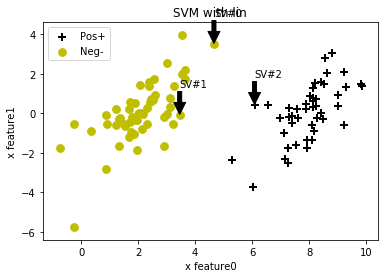

In [31]:
#XS : 支持向量
def show_this_imag(X_train,y_train,XS,rbf_name):
    X=np.mat(X_train)
    y=np.mat(y_train).transpose()
    neg = np.where(y==-1)
    pos = np.where(y==1)
    neg=neg[0]
    pos=pos[0]
    #rint(neg.shape)
    #rint(neg)
    axes = plt.gca()
    X_neg=np.zeros([neg.shape[0],2],np.float32)
    X_pos=np.zeros([pos.shape[0],2],np.float32)
    for i in range(neg.shape[0]):
        X_neg[i]=X[neg[i]]
    for i in range(pos.shape[0]):
        X_pos[i]=X[pos[i]]
        
    axes.scatter(X_pos[:,0], X_pos[:,1], marker='+', c='k', s=60, linewidth=2, label="Pos+")
    axes.scatter(X_neg[:,0], X_neg[:,1], c='y', s=60, label="Neg-")
    axes.set_xlabel("x feature0")
    axes.set_ylabel("x feature1")
    axes.set_title("SVM with %s" %rbf_name)
    axes.legend(frameon= True, fancybox = True);
    
    idx=0
    for i in XS:
        plt.annotate(
        # Label and coordinate
        'SV#%d'%idx, xy=(X[i,0],X[i,1]), xytext=(X[i,0],X[i,1]+1.414),
        # Custom arrow
        arrowprops=dict(facecolor='black', shrink=0.02))
        idx+=1

show_this_imag(X_train,y_train,XS,rbf_name="lin")

### Platt SMO

1. 提供辅助函数选择使Ei-Ej变化最大的j.


$$f(X_k)=(\alpha*y)^T*(XX_k^T)+b$$
$$E_k=f(X_k)-y_k$$

2. 注意一个np.multiply函数

**numpy定义的乘法区别**

```python
A=np.zeros([3,1],np.float32)
B=np.zeros([3,1],np.float32)
A[0]=1
A[1]=2
A[2]=3
B[0]=4
B[1]=5
B[2]=6
C=np.multiply(A,B)# 这个地方都是3x1的,按照矩阵乘法是不可以相乘的.但是这个numpy里边是用的对应位置相乘算的. 当我们的svm里边算fx时也会用到这个.注意这个和矩阵相乘的区别
print(C)
```

**如果是矩阵相乘**

我们本可以这样:
```python
A
B
A*B.T
```

In [8]:
A=np.zeros([3,1],np.float32)
B=np.zeros([3,1],np.float32)
A[0]=1
A[1]=2
A[2]=3
B[0]=4
B[1]=5
B[2]=6
C=np.multiply(A,B)
print(C)

[[  4.]
 [ 10.]
 [ 18.]]


#### 核函数
> 是计算两个向量间的距离,并得出一个标量.
可以把特征从低维度空间向高维度空间映射

1. 高斯径向基核函数

$$K(x,y)=exp(-\frac{||x-y||^2}{2\sigma ^2})$$

**注意**

> \sigma 这个参数减少了每个支持向量对超平面的影响.如果\sigma越小,说明每个支持向量的影响越小,因此越需要更多的支持向量来找到超平面.
反之亦然.

2. 一个i从1到N的样本,有N个样本,每个样本有z个特征值

3. linear 核函数
$$K(x,y)=WX$$

In [9]:
# 两个向量的距离
# X 向量
# A 参考向量
# Kups[0]: 采用的核函数的种类
# Kups[1]: sigma
def kernelTrans(X,Y,kups):
    m,n=X.shape
    K =np.mat(np.zeros((m,1),np.float32))
    if kups[0]=='lin':
        K=X*Y.T
    for i in range(m):
        temp=X[i,:]-Y # 1xn
        K[i,:]=temp*temp.T # 1xn * nx1 ==> 1x1
    K=np.exp(-K/(2*np.power(kups[1],2.0)))
    
    return K # mx1
    

In [23]:
class optStruc:
    # 类的初始化. 
    def __init__(self,dataMatIn,classLabels,C,toler,kups):
        self.X=dataMatIn
        self.y=classLabels.transpose()
        self.C=C
        self.tor=toler
        self.m=dataMatIn.shape[0]
        self.alphas=np.mat(np.zeros((self.m,1),np.float32))
        self.b=0.0#np.mat(np.zeros((self.m,1),np.float32))
        self.eCache=np.mat(np.zeros((self.m,2),np.float32)) # 这里是2列的意思是,第0列是为了标记非边界的j的集合.第1列是对应的Ei-Ej
        self.K=np.mat(np.zeros((self.m,self.m),np.float32))
        for i in range(self.m):
            # 拥有m个mx1的K
            self.K[:,i]=kernelTrans(self.X,self.X[i,:],kups) # 算出第i个mx1.基本上是X本身和X中的第i个样本做距离.
    # 计算第k个alpha和oS的差
def calcEk(oS,k): # 这个oS是self类型的.
    '''
    ##print("calcEk the k=%s",k)
    ##print("oS.alphas shape:",oS.alphas.shape)
    ##print("oS.y shape:",oS.y.shape)
    ##print("oS.X shape:",oS.X.shape)
    ##print("oS.X[k,:].T shape:",oS.X[k,:].T.shape)
    #A=np.multiply(oS.alphas,oS.y).T
    #print("np.multiply(oS.alphas,oS.y).T shape:",A.shape)
    #print("np.multiply(oS.alphas,oS.y).T",A)
    #B=(oS.X*oS.X[k,:].T)
    #print("(oS.X*oS.X[k,:].T) shape",B.shape)
    #print("(oS.X*oS.X[k,:].T)=",B)
    #C=A*B
    #print("np.multiply(oS.alphas,oS.y).T*(oS.X*oS.X[k,:].T) ",C)
    #print("oS.b",oS.b)
    '''

    #fXk=float(np.multiply(oS.alphas,oS.y).T*(oS.X*oS.X[k,:].T))+oS.b   # 非核函数
    fXk=float(np.multiply(oS.alphas,oS.y).T*(oS.K[:,k]))+oS.b  
    
    #fXk=C+oS.b
    #print("FXk with np.multiply(oS.alphas,oS.y).T*(oS.X*oS.X[k,:].T) ",fXk)
    Ek=fXk-float(oS.y[k])
    
    '''
    #print("alphas", oS.alphas)
    #print("y", oS.y)
    #print("X", oS.X)
    #print("Ek=%s,fXk=%s"%(Ek,fXk))
    '''
    return Ek

# 对于外循环i来说,找到内循环的j
# 两种方法:
# 1. 第一次初始化的时候alphas都是0,都在边界上.
#    此时从(1,m)中随机一个非i的值作为j
# 2. 之后选择alphas中不再边界上的非i的alpha.
#    依次计算所有的alpha的E和Ei的差.
#    找最大的差的那个alpha,作为j
def selectJ(i,oS,Ei):
    maxDeltaE=0
    Ej=0
    j=-1 # [ERORO OCCUS ] 做好初始化.
    oS.eCache[i]=[1,Ei]                # 把当前这个alphas[i]标记成非边界的. 并保存其对应的Ei.这个Ei是由上面的calcEk计算而来的.
    validEcacheList=np.nonzero(oS.eCache[:,0].A)[0]
    #print("SelectJ with i:%s, Ei:%s" %(i,Ei))
    #print("validEcacheList:%s"%validEcacheList)
    #print("len(validEcacheList):%s"%len(validEcacheList))
    if len(validEcacheList)>1:
        # 找到最大的Ei－Ej
        for k in validEcacheList:
            #print("validEcacheList's k=%s",k)
            if k==i: # 处理相等条件
                #print("k==i==%s",k)
                continue
            Ek=calcEk(oS,k)           #  oS.eCache[k,1] 此时还没有计算出来呢，不能直接取．
            deltaE=np.abs(Ei-Ek)      #  注意此处需要做abs
            if maxDeltaE<deltaE:
                maxDeltaE=deltaE
                j=k
                Ej=Ek
        #print("j:%s,Ej%s"%(j,Ej))
        return j,Ej
    else:
        j=selectJrand(i,oS.m)
        #print("j:%s,Ej%s"%(j,Ej))
        Ej=calcEk(oS,j)
    return j,Ej

def updateEk(oS,k):
    Ek=calcEk(oS,k)
    oS.eCache[k]=[1,k]
        

In [24]:
#X=np.mat(X_train)
#y=np.mat(y_train).transpose()
#oS=optStruc(X,y.transpose(),0.6,0.001)
#oS.alphas[1]=0.06961952
#calcEk(oS,3)


In [25]:
# 计算内循环
# 考察不满足KKT条件的alphas.
# 更新eta
# 更新L和H
# 及时判断中途的退出点
# 如果不退出了,就计算alphas[i]和alphas[j]的更新
#     同时要更新Ei和Ej到缓存eCache中.
def innerL(i,oS):
    
    DEBUG_SVM=False
    if DEBUG_SVM == True:
        print(oS.X.shape)
        print(oS.y.shape)
        print((np.multiply(oS.alphas,oS.y).T).shape)
    # step1. 选择j
    Ei=calcEk(oS,i)
    j,Ej=selectJ(i,oS,Ei)
       
    # step2. 判断是否满足KKT条件
    if (Ei*oS.y[i]<(-oS.tor)and (alphas[i]<oS.C)or (Ei*oS.y[i]>oS.tor) and (alphas[i]>0)):
        alpha_i_old=alphas[i].copy()
        alpha_j_old=alphas[j].copy()
        if oS.y[i]!=oS.y[j]:
            L=max(0, oS.alphas[j] - oS.alphas[i])
            H=min(oS.C,oS.alphas[j]-oS.alphas[i]+oS.C)
        else:
            L=max(0, oS.alphas[j] + oS.alphas[i]-oS.C)
            H=min(oS.C,oS.alphas[i]+oS.alphas[j])
        if L==H:
            print("L==H")
            return 0
        # 第i行和第j列做一个核函数定义的距离
        eta=2.0*oS.K[i,j]-oS.K[i,i]-oS.K[j,j]
        #eta=2.0*oS.X[i,:]*oS.X[j,:].T-X[i,:]*oS.X[i,:].T-X[j,:]*oS.X[j,:].T # 在没使用核函数时候两个向量的距离
        
        if eta>=0:
            print("eta >=0")
            return 0
        oS.alphas[j]-=oS.y[j]*(Ei-Ej)/eta
        oS.alphas[j]=clipAlpha(oS.alphas[j],H,L)
        updateEk(oS,j)
        if (np.abs(oS.alphas[j]-alpha_j_old)<0.001):
            print("j not moving enough")
            return 0
        oS.alphas[i]+=oS.y[i]*oS.y[j]*(alpha_j_old-oS.alphas[j])
        updateEk(oS,i)
        
        
        ''' 仔细观察这两个区别,你丢掉了oS.x[i,:]
        b1 = oS.b - Ei- oS.y[i]*(oS.alphas[i]-alpha_i_old)*oS.X[i,:] - oS.y[j]*(oS.alphas[j]-alpha_j_old)*oS.X[i,:]*oS.X[j,:].T
        b2 = oS.b - Ej- oS.y[i]*(oS.alphas[i]-alpha_i_old)*oS.X[i,:] - oS.y[j]*(oS.alphas[j]-alpha_j_old)*oS.X[j,:]*oS.X[j,:].T
        '''
        b1 = oS.b - Ei- oS.y[i]*(oS.alphas[i]-alpha_i_old)*oS.K[i,i] - oS.y[j]*(oS.alphas[j]-alpha_j_old)*oS.K[i,j]
        b2 = oS.b - Ej- oS.y[i]*(oS.alphas[i]-alpha_i_old)*oS.K[i,i] - oS.y[j]*(oS.alphas[j]-alpha_j_old)*oS.K[j,j]
        #print("b1",b1)
        #print("b2",b2)
        if (0<alphas[i])and (alphas[i]<oS.C):
            oS.b=b1
        elif (0<alphas[j])and (alphas[j]<oS.C):
            oS.b=b2
        else:
            oS.b=(b1+b2)/2.0
        return 1
    else:
        return 0
    
            

In [26]:
def smoPlatt(X,y,C,toler,maxIter,kups):
    oS=optStruc(X,y.transpose(),C,toler,kups)
    iteritem=0
    entireSet=True
    alphasChanged=0
    
    DEBUG_SVM=True
    if DEBUG_SVM == True:
        print(X.shape)
        print(y.shape)
        
    while (iteritem<maxIter) and ( (alphasChanged>0)or (entireSet)):
        alphasChanged=0
        if entireSet: # 第一次进来,肯定遍历所有的item的.
            for i in range(oS.m):
                alphasChanged+=innerL(i,oS)
                print("fullSet, iter: %d i:%d, pairs changed %d" % (iteritem,i,alphasChanged))
            iteritem+=1
        else: # 仅仅对非边界的alphas做调整.
            #选出既不等于0,也不等于C的alphas
            nonBoundries=np.nonzero((alphas.A>0)*(alphas.A<C))[0]
            for i in nonBoundries:
                alphasChanged+=innerL(i,oS)
                print("non-Boundries, iter: %d i:%d, pairs changed %d" % (iteritem,i,alphasChanged))
            iteritem+=1
        if entireSet:
            entireSet=False
        
        if alphasChanged==0: # 如果内循环没有满足的alpha,此时重新进入遍历. 与simple smo不同的是,simple smo会清零iteritem,导致多次遍历.我们这边仅仅把entirSet标志置位.
            entireSet=True
        print("iteration num :%d",iter)
        
    return oS.b,oS.alphas

X=np.mat(X_train)
y=np.mat(y_train).transpose()
kups=('rbf',1.3)

b,alphas=smoPlatt(X,y,0.6,0.001,40,kups)

(100, 2)
(100, 1)
L==H
fullSet, iter: 0 i:0, pairs changed 0
L==H
fullSet, iter: 0 i:1, pairs changed 0
fullSet, iter: 0 i:2, pairs changed 1
L==H
fullSet, iter: 0 i:3, pairs changed 1
fullSet, iter: 0 i:4, pairs changed 2
fullSet, iter: 0 i:5, pairs changed 3
L==H
fullSet, iter: 0 i:6, pairs changed 3
fullSet, iter: 0 i:7, pairs changed 3
fullSet, iter: 0 i:8, pairs changed 3
fullSet, iter: 0 i:9, pairs changed 4
fullSet, iter: 0 i:10, pairs changed 5
L==H
fullSet, iter: 0 i:11, pairs changed 5
L==H
fullSet, iter: 0 i:12, pairs changed 5
fullSet, iter: 0 i:13, pairs changed 6
fullSet, iter: 0 i:14, pairs changed 6
j not moving enough
fullSet, iter: 0 i:15, pairs changed 6
fullSet, iter: 0 i:16, pairs changed 7
fullSet, iter: 0 i:17, pairs changed 8
fullSet, iter: 0 i:18, pairs changed 9
L==H
fullSet, iter: 0 i:19, pairs changed 9
L==H
fullSet, iter: 0 i:20, pairs changed 9
L==H
fullSet, iter: 0 i:21, pairs changed 9
fullSet, iter: 0 i:22, pairs changed 9
L==H
fullSet, iter: 0 i:23, pa

fullSet, iter: 5 i:50, pairs changed 0
fullSet, iter: 5 i:51, pairs changed 0
j not moving enough
fullSet, iter: 5 i:52, pairs changed 0
fullSet, iter: 5 i:53, pairs changed 0
fullSet, iter: 5 i:54, pairs changed 0
j not moving enough
fullSet, iter: 5 i:55, pairs changed 0
j not moving enough
fullSet, iter: 5 i:56, pairs changed 0
fullSet, iter: 5 i:57, pairs changed 0
fullSet, iter: 5 i:58, pairs changed 0
fullSet, iter: 5 i:59, pairs changed 0
L==H
fullSet, iter: 5 i:60, pairs changed 0
fullSet, iter: 5 i:61, pairs changed 0
fullSet, iter: 5 i:62, pairs changed 0
j not moving enough
fullSet, iter: 5 i:63, pairs changed 0
fullSet, iter: 5 i:64, pairs changed 0
j not moving enough
fullSet, iter: 5 i:65, pairs changed 0
fullSet, iter: 5 i:66, pairs changed 0
fullSet, iter: 5 i:67, pairs changed 0
fullSet, iter: 5 i:68, pairs changed 0
fullSet, iter: 5 i:69, pairs changed 0
j not moving enough
fullSet, iter: 5 i:70, pairs changed 0
fullSet, iter: 5 i:71, pairs changed 0
fullSet, iter: 5 

fullSet, iter: 7 i:67, pairs changed 0
fullSet, iter: 7 i:68, pairs changed 0
fullSet, iter: 7 i:69, pairs changed 0
j not moving enough
fullSet, iter: 7 i:70, pairs changed 0
fullSet, iter: 7 i:71, pairs changed 0
fullSet, iter: 7 i:72, pairs changed 0
fullSet, iter: 7 i:73, pairs changed 0
fullSet, iter: 7 i:74, pairs changed 0
fullSet, iter: 7 i:75, pairs changed 0
fullSet, iter: 7 i:76, pairs changed 0
fullSet, iter: 7 i:77, pairs changed 0
fullSet, iter: 7 i:78, pairs changed 0
fullSet, iter: 7 i:79, pairs changed 0
fullSet, iter: 7 i:80, pairs changed 0
fullSet, iter: 7 i:81, pairs changed 0
fullSet, iter: 7 i:82, pairs changed 0
fullSet, iter: 7 i:83, pairs changed 0
j not moving enough
fullSet, iter: 7 i:84, pairs changed 0
fullSet, iter: 7 i:85, pairs changed 0
fullSet, iter: 7 i:86, pairs changed 0
fullSet, iter: 7 i:87, pairs changed 0
fullSet, iter: 7 i:88, pairs changed 0
fullSet, iter: 7 i:89, pairs changed 0
fullSet, iter: 7 i:90, pairs changed 0
fullSet, iter: 7 i:91, p

L==H
fullSet, iter: 9 i:99, pairs changed 0
iteration num :%d <built-in function iter>
j not moving enough
fullSet, iter: 10 i:0, pairs changed 0
j not moving enough
fullSet, iter: 10 i:1, pairs changed 0
fullSet, iter: 10 i:2, pairs changed 0
fullSet, iter: 10 i:3, pairs changed 0
fullSet, iter: 10 i:4, pairs changed 0
fullSet, iter: 10 i:5, pairs changed 0
fullSet, iter: 10 i:6, pairs changed 0
fullSet, iter: 10 i:7, pairs changed 0
L==H
fullSet, iter: 10 i:8, pairs changed 0
fullSet, iter: 10 i:9, pairs changed 0
j not moving enough
fullSet, iter: 10 i:10, pairs changed 0
fullSet, iter: 10 i:11, pairs changed 0
j not moving enough
fullSet, iter: 10 i:12, pairs changed 0
fullSet, iter: 10 i:13, pairs changed 0
fullSet, iter: 10 i:14, pairs changed 0
fullSet, iter: 10 i:15, pairs changed 0
fullSet, iter: 10 i:16, pairs changed 0
j not moving enough
fullSet, iter: 10 i:17, pairs changed 0
fullSet, iter: 10 i:18, pairs changed 0
fullSet, iter: 10 i:19, pairs changed 0
fullSet, iter: 10 

j not moving enough
fullSet, iter: 12 i:30, pairs changed 0
fullSet, iter: 12 i:31, pairs changed 0
fullSet, iter: 12 i:32, pairs changed 0
fullSet, iter: 12 i:33, pairs changed 0
fullSet, iter: 12 i:34, pairs changed 0
j not moving enough
fullSet, iter: 12 i:35, pairs changed 0
fullSet, iter: 12 i:36, pairs changed 0
fullSet, iter: 12 i:37, pairs changed 0
fullSet, iter: 12 i:38, pairs changed 0
fullSet, iter: 12 i:39, pairs changed 0
fullSet, iter: 12 i:40, pairs changed 0
L==H
fullSet, iter: 12 i:41, pairs changed 0
j not moving enough
fullSet, iter: 12 i:42, pairs changed 0
j not moving enough
fullSet, iter: 12 i:43, pairs changed 0
fullSet, iter: 12 i:44, pairs changed 0
fullSet, iter: 12 i:45, pairs changed 0
fullSet, iter: 12 i:46, pairs changed 0
fullSet, iter: 12 i:47, pairs changed 0
fullSet, iter: 12 i:48, pairs changed 0
fullSet, iter: 12 i:49, pairs changed 0
fullSet, iter: 12 i:50, pairs changed 0
fullSet, iter: 12 i:51, pairs changed 0
j not moving enough
fullSet, iter: 

j not moving enough
fullSet, iter: 14 i:63, pairs changed 0
fullSet, iter: 14 i:64, pairs changed 0
j not moving enough
fullSet, iter: 14 i:65, pairs changed 0
fullSet, iter: 14 i:66, pairs changed 0
fullSet, iter: 14 i:67, pairs changed 0
fullSet, iter: 14 i:68, pairs changed 0
fullSet, iter: 14 i:69, pairs changed 0
j not moving enough
fullSet, iter: 14 i:70, pairs changed 0
fullSet, iter: 14 i:71, pairs changed 0
fullSet, iter: 14 i:72, pairs changed 0
fullSet, iter: 14 i:73, pairs changed 0
fullSet, iter: 14 i:74, pairs changed 0
fullSet, iter: 14 i:75, pairs changed 0
fullSet, iter: 14 i:76, pairs changed 0
fullSet, iter: 14 i:77, pairs changed 0
fullSet, iter: 14 i:78, pairs changed 0
fullSet, iter: 14 i:79, pairs changed 0
fullSet, iter: 14 i:80, pairs changed 0
fullSet, iter: 14 i:81, pairs changed 0
fullSet, iter: 14 i:82, pairs changed 0
fullSet, iter: 14 i:83, pairs changed 0
j not moving enough
fullSet, iter: 14 i:84, pairs changed 0
fullSet, iter: 14 i:85, pairs changed 0


fullSet, iter: 17 i:16, pairs changed 0
j not moving enough
fullSet, iter: 17 i:17, pairs changed 0
fullSet, iter: 17 i:18, pairs changed 0
fullSet, iter: 17 i:19, pairs changed 0
fullSet, iter: 17 i:20, pairs changed 0
fullSet, iter: 17 i:21, pairs changed 0
fullSet, iter: 17 i:22, pairs changed 0
j not moving enough
fullSet, iter: 17 i:23, pairs changed 0
L==H
fullSet, iter: 17 i:24, pairs changed 0
fullSet, iter: 17 i:25, pairs changed 0
fullSet, iter: 17 i:26, pairs changed 0
fullSet, iter: 17 i:27, pairs changed 0
fullSet, iter: 17 i:28, pairs changed 0
j not moving enough
fullSet, iter: 17 i:29, pairs changed 0
j not moving enough
fullSet, iter: 17 i:30, pairs changed 0
fullSet, iter: 17 i:31, pairs changed 0
fullSet, iter: 17 i:32, pairs changed 0
fullSet, iter: 17 i:33, pairs changed 0
fullSet, iter: 17 i:34, pairs changed 0
j not moving enough
fullSet, iter: 17 i:35, pairs changed 0
fullSet, iter: 17 i:36, pairs changed 0
fullSet, iter: 17 i:37, pairs changed 0
fullSet, iter: 

fullSet, iter: 19 i:48, pairs changed 0
fullSet, iter: 19 i:49, pairs changed 0
fullSet, iter: 19 i:50, pairs changed 0
fullSet, iter: 19 i:51, pairs changed 0
j not moving enough
fullSet, iter: 19 i:52, pairs changed 0
fullSet, iter: 19 i:53, pairs changed 0
fullSet, iter: 19 i:54, pairs changed 0
j not moving enough
fullSet, iter: 19 i:55, pairs changed 0
j not moving enough
fullSet, iter: 19 i:56, pairs changed 0
fullSet, iter: 19 i:57, pairs changed 0
fullSet, iter: 19 i:58, pairs changed 0
fullSet, iter: 19 i:59, pairs changed 0
L==H
fullSet, iter: 19 i:60, pairs changed 0
fullSet, iter: 19 i:61, pairs changed 0
fullSet, iter: 19 i:62, pairs changed 0
j not moving enough
fullSet, iter: 19 i:63, pairs changed 0
fullSet, iter: 19 i:64, pairs changed 0
j not moving enough
fullSet, iter: 19 i:65, pairs changed 0
fullSet, iter: 19 i:66, pairs changed 0
fullSet, iter: 19 i:67, pairs changed 0
fullSet, iter: 19 i:68, pairs changed 0
fullSet, iter: 19 i:69, pairs changed 0
j not moving en

fullSet, iter: 22 i:9, pairs changed 0
j not moving enough
fullSet, iter: 22 i:10, pairs changed 0
fullSet, iter: 22 i:11, pairs changed 0
j not moving enough
fullSet, iter: 22 i:12, pairs changed 0
fullSet, iter: 22 i:13, pairs changed 0
fullSet, iter: 22 i:14, pairs changed 0
fullSet, iter: 22 i:15, pairs changed 0
fullSet, iter: 22 i:16, pairs changed 0
j not moving enough
fullSet, iter: 22 i:17, pairs changed 0
fullSet, iter: 22 i:18, pairs changed 0
fullSet, iter: 22 i:19, pairs changed 0
fullSet, iter: 22 i:20, pairs changed 0
fullSet, iter: 22 i:21, pairs changed 0
fullSet, iter: 22 i:22, pairs changed 0
j not moving enough
fullSet, iter: 22 i:23, pairs changed 0
L==H
fullSet, iter: 22 i:24, pairs changed 0
fullSet, iter: 22 i:25, pairs changed 0
fullSet, iter: 22 i:26, pairs changed 0
fullSet, iter: 22 i:27, pairs changed 0
fullSet, iter: 22 i:28, pairs changed 0
j not moving enough
fullSet, iter: 22 i:29, pairs changed 0
j not moving enough
fullSet, iter: 22 i:30, pairs change

fullSet, iter: 24 i:3, pairs changed 0
fullSet, iter: 24 i:4, pairs changed 0
fullSet, iter: 24 i:5, pairs changed 0
fullSet, iter: 24 i:6, pairs changed 0
fullSet, iter: 24 i:7, pairs changed 0
L==H
fullSet, iter: 24 i:8, pairs changed 0
fullSet, iter: 24 i:9, pairs changed 0
j not moving enough
fullSet, iter: 24 i:10, pairs changed 0
fullSet, iter: 24 i:11, pairs changed 0
j not moving enough
fullSet, iter: 24 i:12, pairs changed 0
fullSet, iter: 24 i:13, pairs changed 0
fullSet, iter: 24 i:14, pairs changed 0
fullSet, iter: 24 i:15, pairs changed 0
fullSet, iter: 24 i:16, pairs changed 0
j not moving enough
fullSet, iter: 24 i:17, pairs changed 0
fullSet, iter: 24 i:18, pairs changed 0
fullSet, iter: 24 i:19, pairs changed 0
fullSet, iter: 24 i:20, pairs changed 0
fullSet, iter: 24 i:21, pairs changed 0
fullSet, iter: 24 i:22, pairs changed 0
j not moving enough
fullSet, iter: 24 i:23, pairs changed 0
L==H
fullSet, iter: 24 i:24, pairs changed 0
fullSet, iter: 24 i:25, pairs changed

fullSet, iter: 26 i:69, pairs changed 0
j not moving enough
fullSet, iter: 26 i:70, pairs changed 0
fullSet, iter: 26 i:71, pairs changed 0
fullSet, iter: 26 i:72, pairs changed 0
fullSet, iter: 26 i:73, pairs changed 0
fullSet, iter: 26 i:74, pairs changed 0
fullSet, iter: 26 i:75, pairs changed 0
fullSet, iter: 26 i:76, pairs changed 0
fullSet, iter: 26 i:77, pairs changed 0
fullSet, iter: 26 i:78, pairs changed 0
fullSet, iter: 26 i:79, pairs changed 0
fullSet, iter: 26 i:80, pairs changed 0
fullSet, iter: 26 i:81, pairs changed 0
fullSet, iter: 26 i:82, pairs changed 0
fullSet, iter: 26 i:83, pairs changed 0
j not moving enough
fullSet, iter: 26 i:84, pairs changed 0
fullSet, iter: 26 i:85, pairs changed 0
fullSet, iter: 26 i:86, pairs changed 0
fullSet, iter: 26 i:87, pairs changed 0
fullSet, iter: 26 i:88, pairs changed 0
fullSet, iter: 26 i:89, pairs changed 0
fullSet, iter: 26 i:90, pairs changed 0
fullSet, iter: 26 i:91, pairs changed 0
fullSet, iter: 26 i:92, pairs changed 0


fullSet, iter: 28 i:66, pairs changed 0
fullSet, iter: 28 i:67, pairs changed 0
fullSet, iter: 28 i:68, pairs changed 0
fullSet, iter: 28 i:69, pairs changed 0
j not moving enough
fullSet, iter: 28 i:70, pairs changed 0
fullSet, iter: 28 i:71, pairs changed 0
fullSet, iter: 28 i:72, pairs changed 0
fullSet, iter: 28 i:73, pairs changed 0
fullSet, iter: 28 i:74, pairs changed 0
fullSet, iter: 28 i:75, pairs changed 0
fullSet, iter: 28 i:76, pairs changed 0
fullSet, iter: 28 i:77, pairs changed 0
fullSet, iter: 28 i:78, pairs changed 0
fullSet, iter: 28 i:79, pairs changed 0
fullSet, iter: 28 i:80, pairs changed 0
fullSet, iter: 28 i:81, pairs changed 0
fullSet, iter: 28 i:82, pairs changed 0
fullSet, iter: 28 i:83, pairs changed 0
j not moving enough
fullSet, iter: 28 i:84, pairs changed 0
fullSet, iter: 28 i:85, pairs changed 0
fullSet, iter: 28 i:86, pairs changed 0
fullSet, iter: 28 i:87, pairs changed 0
fullSet, iter: 28 i:88, pairs changed 0
fullSet, iter: 28 i:89, pairs changed 0


fullSet, iter: 30 i:53, pairs changed 0
fullSet, iter: 30 i:54, pairs changed 0
j not moving enough
fullSet, iter: 30 i:55, pairs changed 0
j not moving enough
fullSet, iter: 30 i:56, pairs changed 0
fullSet, iter: 30 i:57, pairs changed 0
fullSet, iter: 30 i:58, pairs changed 0
fullSet, iter: 30 i:59, pairs changed 0
L==H
fullSet, iter: 30 i:60, pairs changed 0
fullSet, iter: 30 i:61, pairs changed 0
fullSet, iter: 30 i:62, pairs changed 0
j not moving enough
fullSet, iter: 30 i:63, pairs changed 0
fullSet, iter: 30 i:64, pairs changed 0
j not moving enough
fullSet, iter: 30 i:65, pairs changed 0
fullSet, iter: 30 i:66, pairs changed 0
fullSet, iter: 30 i:67, pairs changed 0
fullSet, iter: 30 i:68, pairs changed 0
fullSet, iter: 30 i:69, pairs changed 0
j not moving enough
fullSet, iter: 30 i:70, pairs changed 0
fullSet, iter: 30 i:71, pairs changed 0
fullSet, iter: 30 i:72, pairs changed 0
fullSet, iter: 30 i:73, pairs changed 0
fullSet, iter: 30 i:74, pairs changed 0
fullSet, iter: 

fullSet, iter: 32 i:39, pairs changed 0
fullSet, iter: 32 i:40, pairs changed 0
L==H
fullSet, iter: 32 i:41, pairs changed 0
j not moving enough
fullSet, iter: 32 i:42, pairs changed 0
j not moving enough
fullSet, iter: 32 i:43, pairs changed 0
fullSet, iter: 32 i:44, pairs changed 0
fullSet, iter: 32 i:45, pairs changed 0
fullSet, iter: 32 i:46, pairs changed 0
fullSet, iter: 32 i:47, pairs changed 0
fullSet, iter: 32 i:48, pairs changed 0
fullSet, iter: 32 i:49, pairs changed 0
fullSet, iter: 32 i:50, pairs changed 0
fullSet, iter: 32 i:51, pairs changed 0
j not moving enough
fullSet, iter: 32 i:52, pairs changed 0
fullSet, iter: 32 i:53, pairs changed 0
fullSet, iter: 32 i:54, pairs changed 0
j not moving enough
fullSet, iter: 32 i:55, pairs changed 0
j not moving enough
fullSet, iter: 32 i:56, pairs changed 0
fullSet, iter: 32 i:57, pairs changed 0
fullSet, iter: 32 i:58, pairs changed 0
fullSet, iter: 32 i:59, pairs changed 0
L==H
fullSet, iter: 32 i:60, pairs changed 0
fullSet, i

fullSet, iter: 34 i:32, pairs changed 0
fullSet, iter: 34 i:33, pairs changed 0
fullSet, iter: 34 i:34, pairs changed 0
j not moving enough
fullSet, iter: 34 i:35, pairs changed 0
fullSet, iter: 34 i:36, pairs changed 0
fullSet, iter: 34 i:37, pairs changed 0
fullSet, iter: 34 i:38, pairs changed 0
fullSet, iter: 34 i:39, pairs changed 0
fullSet, iter: 34 i:40, pairs changed 0
L==H
fullSet, iter: 34 i:41, pairs changed 0
j not moving enough
fullSet, iter: 34 i:42, pairs changed 0
j not moving enough
fullSet, iter: 34 i:43, pairs changed 0
fullSet, iter: 34 i:44, pairs changed 0
fullSet, iter: 34 i:45, pairs changed 0
fullSet, iter: 34 i:46, pairs changed 0
fullSet, iter: 34 i:47, pairs changed 0
fullSet, iter: 34 i:48, pairs changed 0
fullSet, iter: 34 i:49, pairs changed 0
fullSet, iter: 34 i:50, pairs changed 0
fullSet, iter: 34 i:51, pairs changed 0
j not moving enough
fullSet, iter: 34 i:52, pairs changed 0
fullSet, iter: 34 i:53, pairs changed 0
fullSet, iter: 34 i:54, pairs chang

fullSet, iter: 36 i:45, pairs changed 0
fullSet, iter: 36 i:46, pairs changed 0
fullSet, iter: 36 i:47, pairs changed 0
fullSet, iter: 36 i:48, pairs changed 0
fullSet, iter: 36 i:49, pairs changed 0
fullSet, iter: 36 i:50, pairs changed 0
fullSet, iter: 36 i:51, pairs changed 0
j not moving enough
fullSet, iter: 36 i:52, pairs changed 0
fullSet, iter: 36 i:53, pairs changed 0
fullSet, iter: 36 i:54, pairs changed 0
j not moving enough
fullSet, iter: 36 i:55, pairs changed 0
j not moving enough
fullSet, iter: 36 i:56, pairs changed 0
fullSet, iter: 36 i:57, pairs changed 0
fullSet, iter: 36 i:58, pairs changed 0
fullSet, iter: 36 i:59, pairs changed 0
L==H
fullSet, iter: 36 i:60, pairs changed 0
fullSet, iter: 36 i:61, pairs changed 0
fullSet, iter: 36 i:62, pairs changed 0
j not moving enough
fullSet, iter: 36 i:63, pairs changed 0
fullSet, iter: 36 i:64, pairs changed 0
j not moving enough
fullSet, iter: 36 i:65, pairs changed 0
fullSet, iter: 36 i:66, pairs changed 0
fullSet, iter: 

j not moving enough
fullSet, iter: 38 i:43, pairs changed 0
fullSet, iter: 38 i:44, pairs changed 0
fullSet, iter: 38 i:45, pairs changed 0
fullSet, iter: 38 i:46, pairs changed 0
fullSet, iter: 38 i:47, pairs changed 0
fullSet, iter: 38 i:48, pairs changed 0
fullSet, iter: 38 i:49, pairs changed 0
fullSet, iter: 38 i:50, pairs changed 0
fullSet, iter: 38 i:51, pairs changed 0
j not moving enough
fullSet, iter: 38 i:52, pairs changed 0
fullSet, iter: 38 i:53, pairs changed 0
fullSet, iter: 38 i:54, pairs changed 0
j not moving enough
fullSet, iter: 38 i:55, pairs changed 0
j not moving enough
fullSet, iter: 38 i:56, pairs changed 0
fullSet, iter: 38 i:57, pairs changed 0
fullSet, iter: 38 i:58, pairs changed 0
fullSet, iter: 38 i:59, pairs changed 0
L==H
fullSet, iter: 38 i:60, pairs changed 0
fullSet, iter: 38 i:61, pairs changed 0
fullSet, iter: 38 i:62, pairs changed 0
j not moving enough
fullSet, iter: 38 i:63, pairs changed 0
fullSet, iter: 38 i:64, pairs changed 0
j not moving en

#### 用svm gaussian-rbf的核函数去找特征向量

**结论**
> gaussian rbf找的是圆形的分割,并不一定对于数据有很好的分割.
在这个例子中分割效果还不如linear的核函数.

X[0]:[[ 3.542485  1.977398]]   y[0]:[[-1.]]
X[1]:[[ 3.018896  2.556416]]   y[1]:[[-1.]]
X[2]:[[ 7.55151 -1.58003]]   y[2]:[[ 1.]]
X[3]:[[ 2.114999 -0.004466]]   y[3]:[[-1.]]
X[4]:[[ 8.127113  1.274372]]   y[4]:[[ 1.]]
X[5]:[[ 7.108772 -0.986906]]   y[5]:[[ 1.]]
X[6]:[[ 8.610639  2.046708]]   y[6]:[[ 1.]]
X[9]:[[ 0.341367 -0.894998]]   y[9]:[[-1.]]
X[12]:[[ 0.887835 -2.797792]]   y[12]:[[-1.]]
X[13]:[[ 7.139979 -2.329896]]   y[13]:[[ 1.]]
X[16]:[[ 8.497162 -0.266649]]   y[16]:[[ 1.]]
X[17]:[[ 4.658191  3.507396]]   y[17]:[[-1.]]
X[23]:[[ 3.223038 -0.552392]]   y[23]:[[-1.]]
X[26]:[[ 7.286357  0.251077]]   y[26]:[[ 1.]]
X[28]:[[-0.232542 -0.54769 ]]   y[28]:[[-1.]]
X[29]:[[ 3.457096 -0.082216]]   y[29]:[[-1.]]
X[32]:[[ 8.991748  0.923154]]   y[32]:[[ 1.]]
X[36]:[[ 7.270337 -2.507834]]   y[36]:[[ 1.]]
X[39]:[[ 8.804461  3.044301]]   y[39]:[[ 1.]]
X[42]:[[-0.743036 -1.736103]]   y[42]:[[-1.]]
X[43]:[[ 3.536555  3.96496 ]]   y[43]:[[-1.]]
X[44]:[[ 8.410143  0.025606]]   y[44]:[[ 1.]]
X[47]:

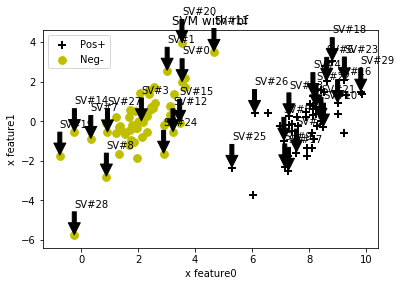

In [32]:
SV=show_support_vectos(alphas,X_train,y_train)
show_this_imag(X_train,y_train,SV,rbf_name="rbf")

### 利用另一个数据集测试rbf


(100, 2)
(100, 1)
L==H
fullSet, iter: 0 i:0, pairs changed 0
fullSet, iter: 0 i:1, pairs changed 1
fullSet, iter: 0 i:2, pairs changed 2
j not moving enough
fullSet, iter: 0 i:3, pairs changed 2
fullSet, iter: 0 i:4, pairs changed 2
fullSet, iter: 0 i:5, pairs changed 2
fullSet, iter: 0 i:6, pairs changed 2
fullSet, iter: 0 i:7, pairs changed 3
fullSet, iter: 0 i:8, pairs changed 3
fullSet, iter: 0 i:9, pairs changed 4
fullSet, iter: 0 i:10, pairs changed 4
L==H
fullSet, iter: 0 i:11, pairs changed 4
fullSet, iter: 0 i:12, pairs changed 5
fullSet, iter: 0 i:13, pairs changed 6
fullSet, iter: 0 i:14, pairs changed 6
fullSet, iter: 0 i:15, pairs changed 7
fullSet, iter: 0 i:16, pairs changed 7
fullSet, iter: 0 i:17, pairs changed 8
fullSet, iter: 0 i:18, pairs changed 9
j not moving enough
fullSet, iter: 0 i:19, pairs changed 9
fullSet, iter: 0 i:20, pairs changed 9
fullSet, iter: 0 i:21, pairs changed 9
j not moving enough
fullSet, iter: 0 i:22, pairs changed 9
j not moving enough
fullS

j not moving enough
non-Boundries, iter: 4 i:22, pairs changed 0
j not moving enough
non-Boundries, iter: 4 i:26, pairs changed 0
j not moving enough
non-Boundries, iter: 4 i:28, pairs changed 0
j not moving enough
non-Boundries, iter: 4 i:29, pairs changed 0
j not moving enough
non-Boundries, iter: 4 i:32, pairs changed 0
j not moving enough
non-Boundries, iter: 4 i:44, pairs changed 0
j not moving enough
non-Boundries, iter: 4 i:47, pairs changed 0
j not moving enough
non-Boundries, iter: 4 i:49, pairs changed 0
j not moving enough
non-Boundries, iter: 4 i:50, pairs changed 0
j not moving enough
non-Boundries, iter: 4 i:52, pairs changed 0
j not moving enough
non-Boundries, iter: 4 i:54, pairs changed 0
j not moving enough
non-Boundries, iter: 4 i:55, pairs changed 0
j not moving enough
non-Boundries, iter: 4 i:68, pairs changed 0
j not moving enough
non-Boundries, iter: 4 i:70, pairs changed 0
j not moving enough
non-Boundries, iter: 4 i:72, pairs changed 0
L==H
non-Boundries, iter:

fullSet, iter: 7 i:6, pairs changed 0
fullSet, iter: 7 i:7, pairs changed 0
fullSet, iter: 7 i:8, pairs changed 0
j not moving enough
fullSet, iter: 7 i:9, pairs changed 0
fullSet, iter: 7 i:10, pairs changed 0
fullSet, iter: 7 i:11, pairs changed 0
j not moving enough
fullSet, iter: 7 i:12, pairs changed 0
j not moving enough
fullSet, iter: 7 i:13, pairs changed 0
fullSet, iter: 7 i:14, pairs changed 0
j not moving enough
fullSet, iter: 7 i:15, pairs changed 0
fullSet, iter: 7 i:16, pairs changed 0
fullSet, iter: 7 i:17, pairs changed 0
fullSet, iter: 7 i:18, pairs changed 0
fullSet, iter: 7 i:19, pairs changed 0
fullSet, iter: 7 i:20, pairs changed 0
fullSet, iter: 7 i:21, pairs changed 0
j not moving enough
fullSet, iter: 7 i:22, pairs changed 0
fullSet, iter: 7 i:23, pairs changed 0
fullSet, iter: 7 i:24, pairs changed 0
fullSet, iter: 7 i:25, pairs changed 0
j not moving enough
fullSet, iter: 7 i:26, pairs changed 0
fullSet, iter: 7 i:27, pairs changed 0
j not moving enough
fullSe

fullSet, iter: 9 i:48, pairs changed 0
j not moving enough
fullSet, iter: 9 i:49, pairs changed 0
j not moving enough
fullSet, iter: 9 i:50, pairs changed 0
fullSet, iter: 9 i:51, pairs changed 0
j not moving enough
fullSet, iter: 9 i:52, pairs changed 0
fullSet, iter: 9 i:53, pairs changed 0
j not moving enough
fullSet, iter: 9 i:54, pairs changed 0
j not moving enough
fullSet, iter: 9 i:55, pairs changed 0
fullSet, iter: 9 i:56, pairs changed 0
fullSet, iter: 9 i:57, pairs changed 0
fullSet, iter: 9 i:58, pairs changed 0
fullSet, iter: 9 i:59, pairs changed 0
fullSet, iter: 9 i:60, pairs changed 0
fullSet, iter: 9 i:61, pairs changed 0
fullSet, iter: 9 i:62, pairs changed 0
fullSet, iter: 9 i:63, pairs changed 0
fullSet, iter: 9 i:64, pairs changed 0
fullSet, iter: 9 i:65, pairs changed 0
fullSet, iter: 9 i:66, pairs changed 0
fullSet, iter: 9 i:67, pairs changed 0
j not moving enough
fullSet, iter: 9 i:68, pairs changed 0
fullSet, iter: 9 i:69, pairs changed 0
j not moving enough
fu

fullSet, iter: 11 i:90, pairs changed 0
fullSet, iter: 11 i:91, pairs changed 0
fullSet, iter: 11 i:92, pairs changed 0
fullSet, iter: 11 i:93, pairs changed 0
fullSet, iter: 11 i:94, pairs changed 0
fullSet, iter: 11 i:95, pairs changed 0
fullSet, iter: 11 i:96, pairs changed 0
fullSet, iter: 11 i:97, pairs changed 0
fullSet, iter: 11 i:98, pairs changed 0
fullSet, iter: 11 i:99, pairs changed 0
iteration num :%d <built-in function iter>
fullSet, iter: 12 i:0, pairs changed 0
fullSet, iter: 12 i:1, pairs changed 0
j not moving enough
fullSet, iter: 12 i:2, pairs changed 0
j not moving enough
fullSet, iter: 12 i:3, pairs changed 0
fullSet, iter: 12 i:4, pairs changed 0
fullSet, iter: 12 i:5, pairs changed 0
fullSet, iter: 12 i:6, pairs changed 0
fullSet, iter: 12 i:7, pairs changed 0
fullSet, iter: 12 i:8, pairs changed 0
j not moving enough
fullSet, iter: 12 i:9, pairs changed 0
fullSet, iter: 12 i:10, pairs changed 0
fullSet, iter: 12 i:11, pairs changed 0
j not moving enough
fullSet

fullSet, iter: 14 i:43, pairs changed 0
j not moving enough
fullSet, iter: 14 i:44, pairs changed 0
fullSet, iter: 14 i:45, pairs changed 0
fullSet, iter: 14 i:46, pairs changed 0
j not moving enough
fullSet, iter: 14 i:47, pairs changed 0
fullSet, iter: 14 i:48, pairs changed 0
j not moving enough
fullSet, iter: 14 i:49, pairs changed 0
j not moving enough
fullSet, iter: 14 i:50, pairs changed 0
fullSet, iter: 14 i:51, pairs changed 0
j not moving enough
fullSet, iter: 14 i:52, pairs changed 0
fullSet, iter: 14 i:53, pairs changed 0
j not moving enough
fullSet, iter: 14 i:54, pairs changed 0
j not moving enough
fullSet, iter: 14 i:55, pairs changed 0
fullSet, iter: 14 i:56, pairs changed 0
fullSet, iter: 14 i:57, pairs changed 0
fullSet, iter: 14 i:58, pairs changed 0
fullSet, iter: 14 i:59, pairs changed 0
fullSet, iter: 14 i:60, pairs changed 0
fullSet, iter: 14 i:61, pairs changed 0
fullSet, iter: 14 i:62, pairs changed 0
fullSet, iter: 14 i:63, pairs changed 0
fullSet, iter: 14 i:

fullSet, iter: 16 i:57, pairs changed 0
fullSet, iter: 16 i:58, pairs changed 0
fullSet, iter: 16 i:59, pairs changed 0
fullSet, iter: 16 i:60, pairs changed 0
fullSet, iter: 16 i:61, pairs changed 0
fullSet, iter: 16 i:62, pairs changed 0
fullSet, iter: 16 i:63, pairs changed 0
fullSet, iter: 16 i:64, pairs changed 0
fullSet, iter: 16 i:65, pairs changed 0
fullSet, iter: 16 i:66, pairs changed 0
fullSet, iter: 16 i:67, pairs changed 0
j not moving enough
fullSet, iter: 16 i:68, pairs changed 0
fullSet, iter: 16 i:69, pairs changed 0
j not moving enough
fullSet, iter: 16 i:70, pairs changed 0
fullSet, iter: 16 i:71, pairs changed 0
j not moving enough
fullSet, iter: 16 i:72, pairs changed 0
fullSet, iter: 16 i:73, pairs changed 0
fullSet, iter: 16 i:74, pairs changed 0
fullSet, iter: 16 i:75, pairs changed 0
L==H
fullSet, iter: 16 i:76, pairs changed 0
j not moving enough
fullSet, iter: 16 i:77, pairs changed 0
fullSet, iter: 16 i:78, pairs changed 0
fullSet, iter: 16 i:79, pairs chang

j not moving enough
fullSet, iter: 19 i:9, pairs changed 0
fullSet, iter: 19 i:10, pairs changed 0
fullSet, iter: 19 i:11, pairs changed 0
j not moving enough
fullSet, iter: 19 i:12, pairs changed 0
j not moving enough
fullSet, iter: 19 i:13, pairs changed 0
fullSet, iter: 19 i:14, pairs changed 0
j not moving enough
fullSet, iter: 19 i:15, pairs changed 0
fullSet, iter: 19 i:16, pairs changed 0
fullSet, iter: 19 i:17, pairs changed 0
fullSet, iter: 19 i:18, pairs changed 0
fullSet, iter: 19 i:19, pairs changed 0
fullSet, iter: 19 i:20, pairs changed 0
fullSet, iter: 19 i:21, pairs changed 0
j not moving enough
fullSet, iter: 19 i:22, pairs changed 0
fullSet, iter: 19 i:23, pairs changed 0
fullSet, iter: 19 i:24, pairs changed 0
fullSet, iter: 19 i:25, pairs changed 0
j not moving enough
fullSet, iter: 19 i:26, pairs changed 0
fullSet, iter: 19 i:27, pairs changed 0
j not moving enough
fullSet, iter: 19 i:28, pairs changed 0
j not moving enough
fullSet, iter: 19 i:29, pairs changed 0
f

fullSet, iter: 20 i:90, pairs changed 0
fullSet, iter: 20 i:91, pairs changed 0
fullSet, iter: 20 i:92, pairs changed 0
fullSet, iter: 20 i:93, pairs changed 0
fullSet, iter: 20 i:94, pairs changed 0
fullSet, iter: 20 i:95, pairs changed 0
fullSet, iter: 20 i:96, pairs changed 0
fullSet, iter: 20 i:97, pairs changed 0
fullSet, iter: 20 i:98, pairs changed 0
fullSet, iter: 20 i:99, pairs changed 0
iteration num :%d <built-in function iter>
fullSet, iter: 21 i:0, pairs changed 0
fullSet, iter: 21 i:1, pairs changed 0
j not moving enough
fullSet, iter: 21 i:2, pairs changed 0
j not moving enough
fullSet, iter: 21 i:3, pairs changed 0
fullSet, iter: 21 i:4, pairs changed 0
fullSet, iter: 21 i:5, pairs changed 0
fullSet, iter: 21 i:6, pairs changed 0
fullSet, iter: 21 i:7, pairs changed 0
fullSet, iter: 21 i:8, pairs changed 0
j not moving enough
fullSet, iter: 21 i:9, pairs changed 0
fullSet, iter: 21 i:10, pairs changed 0
fullSet, iter: 21 i:11, pairs changed 0
j not moving enough
fullSet

L==H
fullSet, iter: 23 i:41, pairs changed 0
L==H
fullSet, iter: 23 i:42, pairs changed 0
fullSet, iter: 23 i:43, pairs changed 0
j not moving enough
fullSet, iter: 23 i:44, pairs changed 0
fullSet, iter: 23 i:45, pairs changed 0
fullSet, iter: 23 i:46, pairs changed 0
j not moving enough
fullSet, iter: 23 i:47, pairs changed 0
fullSet, iter: 23 i:48, pairs changed 0
j not moving enough
fullSet, iter: 23 i:49, pairs changed 0
j not moving enough
fullSet, iter: 23 i:50, pairs changed 0
fullSet, iter: 23 i:51, pairs changed 0
j not moving enough
fullSet, iter: 23 i:52, pairs changed 0
fullSet, iter: 23 i:53, pairs changed 0
j not moving enough
fullSet, iter: 23 i:54, pairs changed 0
j not moving enough
fullSet, iter: 23 i:55, pairs changed 0
fullSet, iter: 23 i:56, pairs changed 0
fullSet, iter: 23 i:57, pairs changed 0
fullSet, iter: 23 i:58, pairs changed 0
fullSet, iter: 23 i:59, pairs changed 0
fullSet, iter: 23 i:60, pairs changed 0
fullSet, iter: 23 i:61, pairs changed 0
fullSet, i

L==H
fullSet, iter: 25 i:41, pairs changed 0
L==H
fullSet, iter: 25 i:42, pairs changed 0
fullSet, iter: 25 i:43, pairs changed 0
j not moving enough
fullSet, iter: 25 i:44, pairs changed 0
fullSet, iter: 25 i:45, pairs changed 0
fullSet, iter: 25 i:46, pairs changed 0
j not moving enough
fullSet, iter: 25 i:47, pairs changed 0
fullSet, iter: 25 i:48, pairs changed 0
j not moving enough
fullSet, iter: 25 i:49, pairs changed 0
j not moving enough
fullSet, iter: 25 i:50, pairs changed 0
fullSet, iter: 25 i:51, pairs changed 0
j not moving enough
fullSet, iter: 25 i:52, pairs changed 0
fullSet, iter: 25 i:53, pairs changed 0
j not moving enough
fullSet, iter: 25 i:54, pairs changed 0
j not moving enough
fullSet, iter: 25 i:55, pairs changed 0
fullSet, iter: 25 i:56, pairs changed 0
fullSet, iter: 25 i:57, pairs changed 0
fullSet, iter: 25 i:58, pairs changed 0
fullSet, iter: 25 i:59, pairs changed 0
fullSet, iter: 25 i:60, pairs changed 0
fullSet, iter: 25 i:61, pairs changed 0
fullSet, i

fullSet, iter: 27 i:53, pairs changed 0
j not moving enough
fullSet, iter: 27 i:54, pairs changed 0
j not moving enough
fullSet, iter: 27 i:55, pairs changed 0
fullSet, iter: 27 i:56, pairs changed 0
fullSet, iter: 27 i:57, pairs changed 0
fullSet, iter: 27 i:58, pairs changed 0
fullSet, iter: 27 i:59, pairs changed 0
fullSet, iter: 27 i:60, pairs changed 0
fullSet, iter: 27 i:61, pairs changed 0
fullSet, iter: 27 i:62, pairs changed 0
fullSet, iter: 27 i:63, pairs changed 0
fullSet, iter: 27 i:64, pairs changed 0
fullSet, iter: 27 i:65, pairs changed 0
fullSet, iter: 27 i:66, pairs changed 0
fullSet, iter: 27 i:67, pairs changed 0
j not moving enough
fullSet, iter: 27 i:68, pairs changed 0
fullSet, iter: 27 i:69, pairs changed 0
j not moving enough
fullSet, iter: 27 i:70, pairs changed 0
fullSet, iter: 27 i:71, pairs changed 0
j not moving enough
fullSet, iter: 27 i:72, pairs changed 0
fullSet, iter: 27 i:73, pairs changed 0
fullSet, iter: 27 i:74, pairs changed 0
fullSet, iter: 27 i:

fullSet, iter: 29 i:59, pairs changed 0
fullSet, iter: 29 i:60, pairs changed 0
fullSet, iter: 29 i:61, pairs changed 0
fullSet, iter: 29 i:62, pairs changed 0
fullSet, iter: 29 i:63, pairs changed 0
fullSet, iter: 29 i:64, pairs changed 0
fullSet, iter: 29 i:65, pairs changed 0
fullSet, iter: 29 i:66, pairs changed 0
fullSet, iter: 29 i:67, pairs changed 0
j not moving enough
fullSet, iter: 29 i:68, pairs changed 0
fullSet, iter: 29 i:69, pairs changed 0
j not moving enough
fullSet, iter: 29 i:70, pairs changed 0
fullSet, iter: 29 i:71, pairs changed 0
j not moving enough
fullSet, iter: 29 i:72, pairs changed 0
fullSet, iter: 29 i:73, pairs changed 0
fullSet, iter: 29 i:74, pairs changed 0
fullSet, iter: 29 i:75, pairs changed 0
L==H
fullSet, iter: 29 i:76, pairs changed 0
j not moving enough
fullSet, iter: 29 i:77, pairs changed 0
fullSet, iter: 29 i:78, pairs changed 0
fullSet, iter: 29 i:79, pairs changed 0
j not moving enough
fullSet, iter: 29 i:80, pairs changed 0
fullSet, iter: 

fullSet, iter: 31 i:65, pairs changed 0
fullSet, iter: 31 i:66, pairs changed 0
fullSet, iter: 31 i:67, pairs changed 0
j not moving enough
fullSet, iter: 31 i:68, pairs changed 0
fullSet, iter: 31 i:69, pairs changed 0
j not moving enough
fullSet, iter: 31 i:70, pairs changed 0
fullSet, iter: 31 i:71, pairs changed 0
j not moving enough
fullSet, iter: 31 i:72, pairs changed 0
fullSet, iter: 31 i:73, pairs changed 0
fullSet, iter: 31 i:74, pairs changed 0
fullSet, iter: 31 i:75, pairs changed 0
L==H
fullSet, iter: 31 i:76, pairs changed 0
j not moving enough
fullSet, iter: 31 i:77, pairs changed 0
fullSet, iter: 31 i:78, pairs changed 0
fullSet, iter: 31 i:79, pairs changed 0
j not moving enough
fullSet, iter: 31 i:80, pairs changed 0
fullSet, iter: 31 i:81, pairs changed 0
fullSet, iter: 31 i:82, pairs changed 0
j not moving enough
fullSet, iter: 31 i:83, pairs changed 0
fullSet, iter: 31 i:84, pairs changed 0
fullSet, iter: 31 i:85, pairs changed 0
fullSet, iter: 31 i:86, pairs chang

fullSet, iter: 34 i:35, pairs changed 0
fullSet, iter: 34 i:36, pairs changed 0
fullSet, iter: 34 i:37, pairs changed 0
fullSet, iter: 34 i:38, pairs changed 0
fullSet, iter: 34 i:39, pairs changed 0
fullSet, iter: 34 i:40, pairs changed 0
L==H
fullSet, iter: 34 i:41, pairs changed 0
L==H
fullSet, iter: 34 i:42, pairs changed 0
fullSet, iter: 34 i:43, pairs changed 0
j not moving enough
fullSet, iter: 34 i:44, pairs changed 0
fullSet, iter: 34 i:45, pairs changed 0
fullSet, iter: 34 i:46, pairs changed 0
j not moving enough
fullSet, iter: 34 i:47, pairs changed 0
fullSet, iter: 34 i:48, pairs changed 0
j not moving enough
fullSet, iter: 34 i:49, pairs changed 0
j not moving enough
fullSet, iter: 34 i:50, pairs changed 0
fullSet, iter: 34 i:51, pairs changed 0
j not moving enough
fullSet, iter: 34 i:52, pairs changed 0
fullSet, iter: 34 i:53, pairs changed 0
j not moving enough
fullSet, iter: 34 i:54, pairs changed 0
j not moving enough
fullSet, iter: 34 i:55, pairs changed 0
fullSet, i

fullSet, iter: 37 i:10, pairs changed 0
fullSet, iter: 37 i:11, pairs changed 0
j not moving enough
fullSet, iter: 37 i:12, pairs changed 0
j not moving enough
fullSet, iter: 37 i:13, pairs changed 0
fullSet, iter: 37 i:14, pairs changed 0
j not moving enough
fullSet, iter: 37 i:15, pairs changed 0
fullSet, iter: 37 i:16, pairs changed 0
fullSet, iter: 37 i:17, pairs changed 0
fullSet, iter: 37 i:18, pairs changed 0
fullSet, iter: 37 i:19, pairs changed 0
fullSet, iter: 37 i:20, pairs changed 0
fullSet, iter: 37 i:21, pairs changed 0
j not moving enough
fullSet, iter: 37 i:22, pairs changed 0
fullSet, iter: 37 i:23, pairs changed 0
fullSet, iter: 37 i:24, pairs changed 0
fullSet, iter: 37 i:25, pairs changed 0
j not moving enough
fullSet, iter: 37 i:26, pairs changed 0
fullSet, iter: 37 i:27, pairs changed 0
j not moving enough
fullSet, iter: 37 i:28, pairs changed 0
j not moving enough
fullSet, iter: 37 i:29, pairs changed 0
fullSet, iter: 37 i:30, pairs changed 0
fullSet, iter: 37 i:

fullSet, iter: 39 i:14, pairs changed 0
j not moving enough
fullSet, iter: 39 i:15, pairs changed 0
fullSet, iter: 39 i:16, pairs changed 0
fullSet, iter: 39 i:17, pairs changed 0
fullSet, iter: 39 i:18, pairs changed 0
fullSet, iter: 39 i:19, pairs changed 0
fullSet, iter: 39 i:20, pairs changed 0
fullSet, iter: 39 i:21, pairs changed 0
j not moving enough
fullSet, iter: 39 i:22, pairs changed 0
fullSet, iter: 39 i:23, pairs changed 0
fullSet, iter: 39 i:24, pairs changed 0
fullSet, iter: 39 i:25, pairs changed 0
j not moving enough
fullSet, iter: 39 i:26, pairs changed 0
fullSet, iter: 39 i:27, pairs changed 0
j not moving enough
fullSet, iter: 39 i:28, pairs changed 0
j not moving enough
fullSet, iter: 39 i:29, pairs changed 0
fullSet, iter: 39 i:30, pairs changed 0
fullSet, iter: 39 i:31, pairs changed 0
j not moving enough
fullSet, iter: 39 i:32, pairs changed 0
fullSet, iter: 39 i:33, pairs changed 0
fullSet, iter: 39 i:34, pairs changed 0
fullSet, iter: 39 i:35, pairs changed 0


fullSet, iter: 41 i:10, pairs changed 0
fullSet, iter: 41 i:11, pairs changed 0
j not moving enough
fullSet, iter: 41 i:12, pairs changed 0
j not moving enough
fullSet, iter: 41 i:13, pairs changed 0
fullSet, iter: 41 i:14, pairs changed 0
j not moving enough
fullSet, iter: 41 i:15, pairs changed 0
fullSet, iter: 41 i:16, pairs changed 0
fullSet, iter: 41 i:17, pairs changed 0
fullSet, iter: 41 i:18, pairs changed 0
fullSet, iter: 41 i:19, pairs changed 0
fullSet, iter: 41 i:20, pairs changed 0
fullSet, iter: 41 i:21, pairs changed 0
j not moving enough
fullSet, iter: 41 i:22, pairs changed 0
fullSet, iter: 41 i:23, pairs changed 0
fullSet, iter: 41 i:24, pairs changed 0
fullSet, iter: 41 i:25, pairs changed 0
j not moving enough
fullSet, iter: 41 i:26, pairs changed 0
fullSet, iter: 41 i:27, pairs changed 0
j not moving enough
fullSet, iter: 41 i:28, pairs changed 0
j not moving enough
fullSet, iter: 41 i:29, pairs changed 0
fullSet, iter: 41 i:30, pairs changed 0
fullSet, iter: 41 i:

fullSet, iter: 43 i:20, pairs changed 0
fullSet, iter: 43 i:21, pairs changed 0
j not moving enough
fullSet, iter: 43 i:22, pairs changed 0
fullSet, iter: 43 i:23, pairs changed 0
fullSet, iter: 43 i:24, pairs changed 0
fullSet, iter: 43 i:25, pairs changed 0
j not moving enough
fullSet, iter: 43 i:26, pairs changed 0
fullSet, iter: 43 i:27, pairs changed 0
j not moving enough
fullSet, iter: 43 i:28, pairs changed 0
j not moving enough
fullSet, iter: 43 i:29, pairs changed 0
fullSet, iter: 43 i:30, pairs changed 0
fullSet, iter: 43 i:31, pairs changed 0
j not moving enough
fullSet, iter: 43 i:32, pairs changed 0
fullSet, iter: 43 i:33, pairs changed 0
fullSet, iter: 43 i:34, pairs changed 0
fullSet, iter: 43 i:35, pairs changed 0
fullSet, iter: 43 i:36, pairs changed 0
fullSet, iter: 43 i:37, pairs changed 0
fullSet, iter: 43 i:38, pairs changed 0
fullSet, iter: 43 i:39, pairs changed 0
fullSet, iter: 43 i:40, pairs changed 0
L==H
fullSet, iter: 43 i:41, pairs changed 0
L==H
fullSet, i

j not moving enough
fullSet, iter: 45 i:28, pairs changed 0
j not moving enough
fullSet, iter: 45 i:29, pairs changed 0
fullSet, iter: 45 i:30, pairs changed 0
fullSet, iter: 45 i:31, pairs changed 0
j not moving enough
fullSet, iter: 45 i:32, pairs changed 0
fullSet, iter: 45 i:33, pairs changed 0
fullSet, iter: 45 i:34, pairs changed 0
fullSet, iter: 45 i:35, pairs changed 0
fullSet, iter: 45 i:36, pairs changed 0
fullSet, iter: 45 i:37, pairs changed 0
fullSet, iter: 45 i:38, pairs changed 0
fullSet, iter: 45 i:39, pairs changed 0
fullSet, iter: 45 i:40, pairs changed 0
L==H
fullSet, iter: 45 i:41, pairs changed 0
L==H
fullSet, iter: 45 i:42, pairs changed 0
fullSet, iter: 45 i:43, pairs changed 0
j not moving enough
fullSet, iter: 45 i:44, pairs changed 0
fullSet, iter: 45 i:45, pairs changed 0
fullSet, iter: 45 i:46, pairs changed 0
j not moving enough
fullSet, iter: 45 i:47, pairs changed 0
fullSet, iter: 45 i:48, pairs changed 0
j not moving enough
fullSet, iter: 45 i:49, pairs 

fullSet, iter: 47 i:62, pairs changed 0
fullSet, iter: 47 i:63, pairs changed 0
fullSet, iter: 47 i:64, pairs changed 0
fullSet, iter: 47 i:65, pairs changed 0
fullSet, iter: 47 i:66, pairs changed 0
fullSet, iter: 47 i:67, pairs changed 0
j not moving enough
fullSet, iter: 47 i:68, pairs changed 0
fullSet, iter: 47 i:69, pairs changed 0
j not moving enough
fullSet, iter: 47 i:70, pairs changed 0
fullSet, iter: 47 i:71, pairs changed 0
j not moving enough
fullSet, iter: 47 i:72, pairs changed 0
fullSet, iter: 47 i:73, pairs changed 0
fullSet, iter: 47 i:74, pairs changed 0
fullSet, iter: 47 i:75, pairs changed 0
L==H
fullSet, iter: 47 i:76, pairs changed 0
j not moving enough
fullSet, iter: 47 i:77, pairs changed 0
fullSet, iter: 47 i:78, pairs changed 0
fullSet, iter: 47 i:79, pairs changed 0
j not moving enough
fullSet, iter: 47 i:80, pairs changed 0
fullSet, iter: 47 i:81, pairs changed 0
fullSet, iter: 47 i:82, pairs changed 0
j not moving enough
fullSet, iter: 47 i:83, pairs chang

fullSet, iter: 50 i:8, pairs changed 0
j not moving enough
fullSet, iter: 50 i:9, pairs changed 0
fullSet, iter: 50 i:10, pairs changed 0
fullSet, iter: 50 i:11, pairs changed 0
j not moving enough
fullSet, iter: 50 i:12, pairs changed 0
j not moving enough
fullSet, iter: 50 i:13, pairs changed 0
fullSet, iter: 50 i:14, pairs changed 0
j not moving enough
fullSet, iter: 50 i:15, pairs changed 0
fullSet, iter: 50 i:16, pairs changed 0
fullSet, iter: 50 i:17, pairs changed 0
fullSet, iter: 50 i:18, pairs changed 0
fullSet, iter: 50 i:19, pairs changed 0
fullSet, iter: 50 i:20, pairs changed 0
fullSet, iter: 50 i:21, pairs changed 0
j not moving enough
fullSet, iter: 50 i:22, pairs changed 0
fullSet, iter: 50 i:23, pairs changed 0
fullSet, iter: 50 i:24, pairs changed 0
fullSet, iter: 50 i:25, pairs changed 0
j not moving enough
fullSet, iter: 50 i:26, pairs changed 0
fullSet, iter: 50 i:27, pairs changed 0
j not moving enough
fullSet, iter: 50 i:28, pairs changed 0
j not moving enough
fu

fullSet, iter: 52 i:60, pairs changed 0
fullSet, iter: 52 i:61, pairs changed 0
fullSet, iter: 52 i:62, pairs changed 0
fullSet, iter: 52 i:63, pairs changed 0
fullSet, iter: 52 i:64, pairs changed 0
fullSet, iter: 52 i:65, pairs changed 0
fullSet, iter: 52 i:66, pairs changed 0
fullSet, iter: 52 i:67, pairs changed 0
j not moving enough
fullSet, iter: 52 i:68, pairs changed 0
fullSet, iter: 52 i:69, pairs changed 0
j not moving enough
fullSet, iter: 52 i:70, pairs changed 0
fullSet, iter: 52 i:71, pairs changed 0
j not moving enough
fullSet, iter: 52 i:72, pairs changed 0
fullSet, iter: 52 i:73, pairs changed 0
fullSet, iter: 52 i:74, pairs changed 0
fullSet, iter: 52 i:75, pairs changed 0
L==H
fullSet, iter: 52 i:76, pairs changed 0
j not moving enough
fullSet, iter: 52 i:77, pairs changed 0
fullSet, iter: 52 i:78, pairs changed 0
fullSet, iter: 52 i:79, pairs changed 0
j not moving enough
fullSet, iter: 52 i:80, pairs changed 0
fullSet, iter: 52 i:81, pairs changed 0
fullSet, iter: 

fullSet, iter: 55 i:11, pairs changed 0
j not moving enough
fullSet, iter: 55 i:12, pairs changed 0
j not moving enough
fullSet, iter: 55 i:13, pairs changed 0
fullSet, iter: 55 i:14, pairs changed 0
j not moving enough
fullSet, iter: 55 i:15, pairs changed 0
fullSet, iter: 55 i:16, pairs changed 0
fullSet, iter: 55 i:17, pairs changed 0
fullSet, iter: 55 i:18, pairs changed 0
fullSet, iter: 55 i:19, pairs changed 0
fullSet, iter: 55 i:20, pairs changed 0
fullSet, iter: 55 i:21, pairs changed 0
j not moving enough
fullSet, iter: 55 i:22, pairs changed 0
fullSet, iter: 55 i:23, pairs changed 0
fullSet, iter: 55 i:24, pairs changed 0
fullSet, iter: 55 i:25, pairs changed 0
j not moving enough
fullSet, iter: 55 i:26, pairs changed 0
fullSet, iter: 55 i:27, pairs changed 0
j not moving enough
fullSet, iter: 55 i:28, pairs changed 0
j not moving enough
fullSet, iter: 55 i:29, pairs changed 0
fullSet, iter: 55 i:30, pairs changed 0
fullSet, iter: 55 i:31, pairs changed 0
j not moving enough


fullSet, iter: 57 i:58, pairs changed 0
fullSet, iter: 57 i:59, pairs changed 0
fullSet, iter: 57 i:60, pairs changed 0
fullSet, iter: 57 i:61, pairs changed 0
fullSet, iter: 57 i:62, pairs changed 0
fullSet, iter: 57 i:63, pairs changed 0
fullSet, iter: 57 i:64, pairs changed 0
fullSet, iter: 57 i:65, pairs changed 0
fullSet, iter: 57 i:66, pairs changed 0
fullSet, iter: 57 i:67, pairs changed 0
j not moving enough
fullSet, iter: 57 i:68, pairs changed 0
fullSet, iter: 57 i:69, pairs changed 0
j not moving enough
fullSet, iter: 57 i:70, pairs changed 0
fullSet, iter: 57 i:71, pairs changed 0
j not moving enough
fullSet, iter: 57 i:72, pairs changed 0
fullSet, iter: 57 i:73, pairs changed 0
fullSet, iter: 57 i:74, pairs changed 0
fullSet, iter: 57 i:75, pairs changed 0
L==H
fullSet, iter: 57 i:76, pairs changed 0
j not moving enough
fullSet, iter: 57 i:77, pairs changed 0
fullSet, iter: 57 i:78, pairs changed 0
fullSet, iter: 57 i:79, pairs changed 0
j not moving enough
fullSet, iter: 

L==H
fullSet, iter: 59 i:42, pairs changed 0
fullSet, iter: 59 i:43, pairs changed 0
j not moving enough
fullSet, iter: 59 i:44, pairs changed 0
fullSet, iter: 59 i:45, pairs changed 0
fullSet, iter: 59 i:46, pairs changed 0
j not moving enough
fullSet, iter: 59 i:47, pairs changed 0
fullSet, iter: 59 i:48, pairs changed 0
j not moving enough
fullSet, iter: 59 i:49, pairs changed 0
j not moving enough
fullSet, iter: 59 i:50, pairs changed 0
fullSet, iter: 59 i:51, pairs changed 0
j not moving enough
fullSet, iter: 59 i:52, pairs changed 0
fullSet, iter: 59 i:53, pairs changed 0
j not moving enough
fullSet, iter: 59 i:54, pairs changed 0
j not moving enough
fullSet, iter: 59 i:55, pairs changed 0
fullSet, iter: 59 i:56, pairs changed 0
fullSet, iter: 59 i:57, pairs changed 0
fullSet, iter: 59 i:58, pairs changed 0
fullSet, iter: 59 i:59, pairs changed 0
fullSet, iter: 59 i:60, pairs changed 0
fullSet, iter: 59 i:61, pairs changed 0
fullSet, iter: 59 i:62, pairs changed 0
fullSet, iter: 

fullSet, iter: 61 i:23, pairs changed 0
fullSet, iter: 61 i:24, pairs changed 0
fullSet, iter: 61 i:25, pairs changed 0
j not moving enough
fullSet, iter: 61 i:26, pairs changed 0
fullSet, iter: 61 i:27, pairs changed 0
j not moving enough
fullSet, iter: 61 i:28, pairs changed 0
j not moving enough
fullSet, iter: 61 i:29, pairs changed 0
fullSet, iter: 61 i:30, pairs changed 0
fullSet, iter: 61 i:31, pairs changed 0
j not moving enough
fullSet, iter: 61 i:32, pairs changed 0
fullSet, iter: 61 i:33, pairs changed 0
fullSet, iter: 61 i:34, pairs changed 0
fullSet, iter: 61 i:35, pairs changed 0
fullSet, iter: 61 i:36, pairs changed 0
fullSet, iter: 61 i:37, pairs changed 0
fullSet, iter: 61 i:38, pairs changed 0
fullSet, iter: 61 i:39, pairs changed 0
fullSet, iter: 61 i:40, pairs changed 0
L==H
fullSet, iter: 61 i:41, pairs changed 0
L==H
fullSet, iter: 61 i:42, pairs changed 0
fullSet, iter: 61 i:43, pairs changed 0
j not moving enough
fullSet, iter: 61 i:44, pairs changed 0
fullSet, i

fullSet, iter: 63 i:14, pairs changed 0
j not moving enough
fullSet, iter: 63 i:15, pairs changed 0
fullSet, iter: 63 i:16, pairs changed 0
fullSet, iter: 63 i:17, pairs changed 0
fullSet, iter: 63 i:18, pairs changed 0
fullSet, iter: 63 i:19, pairs changed 0
fullSet, iter: 63 i:20, pairs changed 0
fullSet, iter: 63 i:21, pairs changed 0
j not moving enough
fullSet, iter: 63 i:22, pairs changed 0
fullSet, iter: 63 i:23, pairs changed 0
fullSet, iter: 63 i:24, pairs changed 0
fullSet, iter: 63 i:25, pairs changed 0
j not moving enough
fullSet, iter: 63 i:26, pairs changed 0
fullSet, iter: 63 i:27, pairs changed 0
j not moving enough
fullSet, iter: 63 i:28, pairs changed 0
j not moving enough
fullSet, iter: 63 i:29, pairs changed 0
fullSet, iter: 63 i:30, pairs changed 0
fullSet, iter: 63 i:31, pairs changed 0
j not moving enough
fullSet, iter: 63 i:32, pairs changed 0
fullSet, iter: 63 i:33, pairs changed 0
fullSet, iter: 63 i:34, pairs changed 0
fullSet, iter: 63 i:35, pairs changed 0


fullSet, iter: 65 i:27, pairs changed 0
j not moving enough
fullSet, iter: 65 i:28, pairs changed 0
j not moving enough
fullSet, iter: 65 i:29, pairs changed 0
fullSet, iter: 65 i:30, pairs changed 0
fullSet, iter: 65 i:31, pairs changed 0
j not moving enough
fullSet, iter: 65 i:32, pairs changed 0
fullSet, iter: 65 i:33, pairs changed 0
fullSet, iter: 65 i:34, pairs changed 0
fullSet, iter: 65 i:35, pairs changed 0
fullSet, iter: 65 i:36, pairs changed 0
fullSet, iter: 65 i:37, pairs changed 0
fullSet, iter: 65 i:38, pairs changed 0
fullSet, iter: 65 i:39, pairs changed 0
fullSet, iter: 65 i:40, pairs changed 0
L==H
fullSet, iter: 65 i:41, pairs changed 0
L==H
fullSet, iter: 65 i:42, pairs changed 0
fullSet, iter: 65 i:43, pairs changed 0
j not moving enough
fullSet, iter: 65 i:44, pairs changed 0
fullSet, iter: 65 i:45, pairs changed 0
fullSet, iter: 65 i:46, pairs changed 0
j not moving enough
fullSet, iter: 65 i:47, pairs changed 0
fullSet, iter: 65 i:48, pairs changed 0
j not movi

fullSet, iter: 67 i:90, pairs changed 0
fullSet, iter: 67 i:91, pairs changed 0
fullSet, iter: 67 i:92, pairs changed 0
fullSet, iter: 67 i:93, pairs changed 0
fullSet, iter: 67 i:94, pairs changed 0
fullSet, iter: 67 i:95, pairs changed 0
fullSet, iter: 67 i:96, pairs changed 0
fullSet, iter: 67 i:97, pairs changed 0
fullSet, iter: 67 i:98, pairs changed 0
fullSet, iter: 67 i:99, pairs changed 0
iteration num :%d <built-in function iter>
fullSet, iter: 68 i:0, pairs changed 0
fullSet, iter: 68 i:1, pairs changed 0
j not moving enough
fullSet, iter: 68 i:2, pairs changed 0
j not moving enough
fullSet, iter: 68 i:3, pairs changed 0
fullSet, iter: 68 i:4, pairs changed 0
fullSet, iter: 68 i:5, pairs changed 0
fullSet, iter: 68 i:6, pairs changed 0
fullSet, iter: 68 i:7, pairs changed 0
fullSet, iter: 68 i:8, pairs changed 0
j not moving enough
fullSet, iter: 68 i:9, pairs changed 0
fullSet, iter: 68 i:10, pairs changed 0
fullSet, iter: 68 i:11, pairs changed 0
j not moving enough
fullSet

fullSet, iter: 69 i:85, pairs changed 0
fullSet, iter: 69 i:86, pairs changed 0
L==H
fullSet, iter: 69 i:87, pairs changed 0
fullSet, iter: 69 i:88, pairs changed 0
fullSet, iter: 69 i:89, pairs changed 0
fullSet, iter: 69 i:90, pairs changed 0
fullSet, iter: 69 i:91, pairs changed 0
fullSet, iter: 69 i:92, pairs changed 0
fullSet, iter: 69 i:93, pairs changed 0
fullSet, iter: 69 i:94, pairs changed 0
fullSet, iter: 69 i:95, pairs changed 0
fullSet, iter: 69 i:96, pairs changed 0
fullSet, iter: 69 i:97, pairs changed 0
fullSet, iter: 69 i:98, pairs changed 0
fullSet, iter: 69 i:99, pairs changed 0
iteration num :%d <built-in function iter>
fullSet, iter: 70 i:0, pairs changed 0
fullSet, iter: 70 i:1, pairs changed 0
j not moving enough
fullSet, iter: 70 i:2, pairs changed 0
j not moving enough
fullSet, iter: 70 i:3, pairs changed 0
fullSet, iter: 70 i:4, pairs changed 0
fullSet, iter: 70 i:5, pairs changed 0
fullSet, iter: 70 i:6, pairs changed 0
fullSet, iter: 70 i:7, pairs changed 0


fullSet, iter: 71 i:73, pairs changed 0
fullSet, iter: 71 i:74, pairs changed 0
fullSet, iter: 71 i:75, pairs changed 0
L==H
fullSet, iter: 71 i:76, pairs changed 0
j not moving enough
fullSet, iter: 71 i:77, pairs changed 0
fullSet, iter: 71 i:78, pairs changed 0
fullSet, iter: 71 i:79, pairs changed 0
j not moving enough
fullSet, iter: 71 i:80, pairs changed 0
fullSet, iter: 71 i:81, pairs changed 0
fullSet, iter: 71 i:82, pairs changed 0
j not moving enough
fullSet, iter: 71 i:83, pairs changed 0
fullSet, iter: 71 i:84, pairs changed 0
fullSet, iter: 71 i:85, pairs changed 0
fullSet, iter: 71 i:86, pairs changed 0
L==H
fullSet, iter: 71 i:87, pairs changed 0
fullSet, iter: 71 i:88, pairs changed 0
fullSet, iter: 71 i:89, pairs changed 0
fullSet, iter: 71 i:90, pairs changed 0
fullSet, iter: 71 i:91, pairs changed 0
fullSet, iter: 71 i:92, pairs changed 0
fullSet, iter: 71 i:93, pairs changed 0
fullSet, iter: 71 i:94, pairs changed 0
fullSet, iter: 71 i:95, pairs changed 0
fullSet, i

fullSet, iter: 73 i:63, pairs changed 0
fullSet, iter: 73 i:64, pairs changed 0
fullSet, iter: 73 i:65, pairs changed 0
fullSet, iter: 73 i:66, pairs changed 0
fullSet, iter: 73 i:67, pairs changed 0
j not moving enough
fullSet, iter: 73 i:68, pairs changed 0
fullSet, iter: 73 i:69, pairs changed 0
j not moving enough
fullSet, iter: 73 i:70, pairs changed 0
fullSet, iter: 73 i:71, pairs changed 0
j not moving enough
fullSet, iter: 73 i:72, pairs changed 0
fullSet, iter: 73 i:73, pairs changed 0
fullSet, iter: 73 i:74, pairs changed 0
fullSet, iter: 73 i:75, pairs changed 0
L==H
fullSet, iter: 73 i:76, pairs changed 0
j not moving enough
fullSet, iter: 73 i:77, pairs changed 0
fullSet, iter: 73 i:78, pairs changed 0
fullSet, iter: 73 i:79, pairs changed 0
j not moving enough
fullSet, iter: 73 i:80, pairs changed 0
fullSet, iter: 73 i:81, pairs changed 0
fullSet, iter: 73 i:82, pairs changed 0
j not moving enough
fullSet, iter: 73 i:83, pairs changed 0
fullSet, iter: 73 i:84, pairs chang

fullSet, iter: 75 i:66, pairs changed 0
fullSet, iter: 75 i:67, pairs changed 0
j not moving enough
fullSet, iter: 75 i:68, pairs changed 0
fullSet, iter: 75 i:69, pairs changed 0
j not moving enough
fullSet, iter: 75 i:70, pairs changed 0
fullSet, iter: 75 i:71, pairs changed 0
j not moving enough
fullSet, iter: 75 i:72, pairs changed 0
fullSet, iter: 75 i:73, pairs changed 0
fullSet, iter: 75 i:74, pairs changed 0
fullSet, iter: 75 i:75, pairs changed 0
L==H
fullSet, iter: 75 i:76, pairs changed 0
j not moving enough
fullSet, iter: 75 i:77, pairs changed 0
fullSet, iter: 75 i:78, pairs changed 0
fullSet, iter: 75 i:79, pairs changed 0
j not moving enough
fullSet, iter: 75 i:80, pairs changed 0
fullSet, iter: 75 i:81, pairs changed 0
fullSet, iter: 75 i:82, pairs changed 0
j not moving enough
fullSet, iter: 75 i:83, pairs changed 0
fullSet, iter: 75 i:84, pairs changed 0
fullSet, iter: 75 i:85, pairs changed 0
fullSet, iter: 75 i:86, pairs changed 0
L==H
fullSet, iter: 75 i:87, pairs 

fullSet, iter: 77 i:60, pairs changed 0
fullSet, iter: 77 i:61, pairs changed 0
fullSet, iter: 77 i:62, pairs changed 0
fullSet, iter: 77 i:63, pairs changed 0
fullSet, iter: 77 i:64, pairs changed 0
fullSet, iter: 77 i:65, pairs changed 0
fullSet, iter: 77 i:66, pairs changed 0
fullSet, iter: 77 i:67, pairs changed 0
j not moving enough
fullSet, iter: 77 i:68, pairs changed 0
fullSet, iter: 77 i:69, pairs changed 0
j not moving enough
fullSet, iter: 77 i:70, pairs changed 0
fullSet, iter: 77 i:71, pairs changed 0
j not moving enough
fullSet, iter: 77 i:72, pairs changed 0
fullSet, iter: 77 i:73, pairs changed 0
fullSet, iter: 77 i:74, pairs changed 0
fullSet, iter: 77 i:75, pairs changed 0
L==H
fullSet, iter: 77 i:76, pairs changed 0
j not moving enough
fullSet, iter: 77 i:77, pairs changed 0
fullSet, iter: 77 i:78, pairs changed 0
fullSet, iter: 77 i:79, pairs changed 0
j not moving enough
fullSet, iter: 77 i:80, pairs changed 0
fullSet, iter: 77 i:81, pairs changed 0
fullSet, iter: 

fullSet, iter: 79 i:46, pairs changed 0
j not moving enough
fullSet, iter: 79 i:47, pairs changed 0
fullSet, iter: 79 i:48, pairs changed 0
j not moving enough
fullSet, iter: 79 i:49, pairs changed 0
j not moving enough
fullSet, iter: 79 i:50, pairs changed 0
fullSet, iter: 79 i:51, pairs changed 0
j not moving enough
fullSet, iter: 79 i:52, pairs changed 0
fullSet, iter: 79 i:53, pairs changed 0
j not moving enough
fullSet, iter: 79 i:54, pairs changed 0
j not moving enough
fullSet, iter: 79 i:55, pairs changed 0
fullSet, iter: 79 i:56, pairs changed 0
fullSet, iter: 79 i:57, pairs changed 0
fullSet, iter: 79 i:58, pairs changed 0
fullSet, iter: 79 i:59, pairs changed 0
fullSet, iter: 79 i:60, pairs changed 0
fullSet, iter: 79 i:61, pairs changed 0
fullSet, iter: 79 i:62, pairs changed 0
fullSet, iter: 79 i:63, pairs changed 0
fullSet, iter: 79 i:64, pairs changed 0
fullSet, iter: 79 i:65, pairs changed 0
fullSet, iter: 79 i:66, pairs changed 0
fullSet, iter: 79 i:67, pairs changed 0


fullSet, iter: 81 i:44, pairs changed 0
fullSet, iter: 81 i:45, pairs changed 0
fullSet, iter: 81 i:46, pairs changed 0
j not moving enough
fullSet, iter: 81 i:47, pairs changed 0
fullSet, iter: 81 i:48, pairs changed 0
j not moving enough
fullSet, iter: 81 i:49, pairs changed 0
j not moving enough
fullSet, iter: 81 i:50, pairs changed 0
fullSet, iter: 81 i:51, pairs changed 0
j not moving enough
fullSet, iter: 81 i:52, pairs changed 0
fullSet, iter: 81 i:53, pairs changed 0
j not moving enough
fullSet, iter: 81 i:54, pairs changed 0
j not moving enough
fullSet, iter: 81 i:55, pairs changed 0
fullSet, iter: 81 i:56, pairs changed 0
fullSet, iter: 81 i:57, pairs changed 0
fullSet, iter: 81 i:58, pairs changed 0
fullSet, iter: 81 i:59, pairs changed 0
fullSet, iter: 81 i:60, pairs changed 0
fullSet, iter: 81 i:61, pairs changed 0
fullSet, iter: 81 i:62, pairs changed 0
fullSet, iter: 81 i:63, pairs changed 0
fullSet, iter: 81 i:64, pairs changed 0
fullSet, iter: 81 i:65, pairs changed 0


fullSet, iter: 83 i:45, pairs changed 0
fullSet, iter: 83 i:46, pairs changed 0
j not moving enough
fullSet, iter: 83 i:47, pairs changed 0
fullSet, iter: 83 i:48, pairs changed 0
j not moving enough
fullSet, iter: 83 i:49, pairs changed 0
j not moving enough
fullSet, iter: 83 i:50, pairs changed 0
fullSet, iter: 83 i:51, pairs changed 0
j not moving enough
fullSet, iter: 83 i:52, pairs changed 0
fullSet, iter: 83 i:53, pairs changed 0
j not moving enough
fullSet, iter: 83 i:54, pairs changed 0
j not moving enough
fullSet, iter: 83 i:55, pairs changed 0
fullSet, iter: 83 i:56, pairs changed 0
fullSet, iter: 83 i:57, pairs changed 0
fullSet, iter: 83 i:58, pairs changed 0
fullSet, iter: 83 i:59, pairs changed 0
fullSet, iter: 83 i:60, pairs changed 0
fullSet, iter: 83 i:61, pairs changed 0
fullSet, iter: 83 i:62, pairs changed 0
fullSet, iter: 83 i:63, pairs changed 0
fullSet, iter: 83 i:64, pairs changed 0
fullSet, iter: 83 i:65, pairs changed 0
fullSet, iter: 83 i:66, pairs changed 0


fullSet, iter: 85 i:75, pairs changed 0
L==H
fullSet, iter: 85 i:76, pairs changed 0
j not moving enough
fullSet, iter: 85 i:77, pairs changed 0
fullSet, iter: 85 i:78, pairs changed 0
fullSet, iter: 85 i:79, pairs changed 0
j not moving enough
fullSet, iter: 85 i:80, pairs changed 0
fullSet, iter: 85 i:81, pairs changed 0
fullSet, iter: 85 i:82, pairs changed 0
j not moving enough
fullSet, iter: 85 i:83, pairs changed 0
fullSet, iter: 85 i:84, pairs changed 0
fullSet, iter: 85 i:85, pairs changed 0
fullSet, iter: 85 i:86, pairs changed 0
L==H
fullSet, iter: 85 i:87, pairs changed 0
fullSet, iter: 85 i:88, pairs changed 0
fullSet, iter: 85 i:89, pairs changed 0
fullSet, iter: 85 i:90, pairs changed 0
fullSet, iter: 85 i:91, pairs changed 0
fullSet, iter: 85 i:92, pairs changed 0
fullSet, iter: 85 i:93, pairs changed 0
fullSet, iter: 85 i:94, pairs changed 0
fullSet, iter: 85 i:95, pairs changed 0
fullSet, iter: 85 i:96, pairs changed 0
fullSet, iter: 85 i:97, pairs changed 0
fullSet, i

j not moving enough
fullSet, iter: 88 i:12, pairs changed 0
j not moving enough
fullSet, iter: 88 i:13, pairs changed 0
fullSet, iter: 88 i:14, pairs changed 0
j not moving enough
fullSet, iter: 88 i:15, pairs changed 0
fullSet, iter: 88 i:16, pairs changed 0
fullSet, iter: 88 i:17, pairs changed 0
fullSet, iter: 88 i:18, pairs changed 0
fullSet, iter: 88 i:19, pairs changed 0
fullSet, iter: 88 i:20, pairs changed 0
fullSet, iter: 88 i:21, pairs changed 0
j not moving enough
fullSet, iter: 88 i:22, pairs changed 0
fullSet, iter: 88 i:23, pairs changed 0
fullSet, iter: 88 i:24, pairs changed 0
fullSet, iter: 88 i:25, pairs changed 0
j not moving enough
fullSet, iter: 88 i:26, pairs changed 0
fullSet, iter: 88 i:27, pairs changed 0
j not moving enough
fullSet, iter: 88 i:28, pairs changed 0
j not moving enough
fullSet, iter: 88 i:29, pairs changed 0
fullSet, iter: 88 i:30, pairs changed 0
fullSet, iter: 88 i:31, pairs changed 0
j not moving enough
fullSet, iter: 88 i:32, pairs changed 0


fullSet, iter: 90 i:30, pairs changed 0
fullSet, iter: 90 i:31, pairs changed 0
j not moving enough
fullSet, iter: 90 i:32, pairs changed 0
fullSet, iter: 90 i:33, pairs changed 0
fullSet, iter: 90 i:34, pairs changed 0
fullSet, iter: 90 i:35, pairs changed 0
fullSet, iter: 90 i:36, pairs changed 0
fullSet, iter: 90 i:37, pairs changed 0
fullSet, iter: 90 i:38, pairs changed 0
fullSet, iter: 90 i:39, pairs changed 0
fullSet, iter: 90 i:40, pairs changed 0
L==H
fullSet, iter: 90 i:41, pairs changed 0
L==H
fullSet, iter: 90 i:42, pairs changed 0
fullSet, iter: 90 i:43, pairs changed 0
j not moving enough
fullSet, iter: 90 i:44, pairs changed 0
fullSet, iter: 90 i:45, pairs changed 0
fullSet, iter: 90 i:46, pairs changed 0
j not moving enough
fullSet, iter: 90 i:47, pairs changed 0
fullSet, iter: 90 i:48, pairs changed 0
j not moving enough
fullSet, iter: 90 i:49, pairs changed 0
j not moving enough
fullSet, iter: 90 i:50, pairs changed 0
fullSet, iter: 90 i:51, pairs changed 0
j not movi

fullSet, iter: 92 i:90, pairs changed 0
fullSet, iter: 92 i:91, pairs changed 0
fullSet, iter: 92 i:92, pairs changed 0
fullSet, iter: 92 i:93, pairs changed 0
fullSet, iter: 92 i:94, pairs changed 0
fullSet, iter: 92 i:95, pairs changed 0
fullSet, iter: 92 i:96, pairs changed 0
fullSet, iter: 92 i:97, pairs changed 0
fullSet, iter: 92 i:98, pairs changed 0
fullSet, iter: 92 i:99, pairs changed 0
iteration num :%d <built-in function iter>
fullSet, iter: 93 i:0, pairs changed 0
fullSet, iter: 93 i:1, pairs changed 0
j not moving enough
fullSet, iter: 93 i:2, pairs changed 0
j not moving enough
fullSet, iter: 93 i:3, pairs changed 0
fullSet, iter: 93 i:4, pairs changed 0
fullSet, iter: 93 i:5, pairs changed 0
fullSet, iter: 93 i:6, pairs changed 0
fullSet, iter: 93 i:7, pairs changed 0
fullSet, iter: 93 i:8, pairs changed 0
j not moving enough
fullSet, iter: 93 i:9, pairs changed 0
fullSet, iter: 93 i:10, pairs changed 0
fullSet, iter: 93 i:11, pairs changed 0
j not moving enough
fullSet

fullSet, iter: 94 i:99, pairs changed 0
iteration num :%d <built-in function iter>
fullSet, iter: 95 i:0, pairs changed 0
fullSet, iter: 95 i:1, pairs changed 0
j not moving enough
fullSet, iter: 95 i:2, pairs changed 0
j not moving enough
fullSet, iter: 95 i:3, pairs changed 0
fullSet, iter: 95 i:4, pairs changed 0
fullSet, iter: 95 i:5, pairs changed 0
fullSet, iter: 95 i:6, pairs changed 0
fullSet, iter: 95 i:7, pairs changed 0
fullSet, iter: 95 i:8, pairs changed 0
j not moving enough
fullSet, iter: 95 i:9, pairs changed 0
fullSet, iter: 95 i:10, pairs changed 0
fullSet, iter: 95 i:11, pairs changed 0
j not moving enough
fullSet, iter: 95 i:12, pairs changed 0
j not moving enough
fullSet, iter: 95 i:13, pairs changed 0
fullSet, iter: 95 i:14, pairs changed 0
j not moving enough
fullSet, iter: 95 i:15, pairs changed 0
fullSet, iter: 95 i:16, pairs changed 0
fullSet, iter: 95 i:17, pairs changed 0
fullSet, iter: 95 i:18, pairs changed 0
fullSet, iter: 95 i:19, pairs changed 0
fullSet

j not moving enough
fullSet, iter: 97 i:9, pairs changed 0
fullSet, iter: 97 i:10, pairs changed 0
fullSet, iter: 97 i:11, pairs changed 0
j not moving enough
fullSet, iter: 97 i:12, pairs changed 0
j not moving enough
fullSet, iter: 97 i:13, pairs changed 0
fullSet, iter: 97 i:14, pairs changed 0
j not moving enough
fullSet, iter: 97 i:15, pairs changed 0
fullSet, iter: 97 i:16, pairs changed 0
fullSet, iter: 97 i:17, pairs changed 0
fullSet, iter: 97 i:18, pairs changed 0
fullSet, iter: 97 i:19, pairs changed 0
fullSet, iter: 97 i:20, pairs changed 0
fullSet, iter: 97 i:21, pairs changed 0
j not moving enough
fullSet, iter: 97 i:22, pairs changed 0
fullSet, iter: 97 i:23, pairs changed 0
fullSet, iter: 97 i:24, pairs changed 0
fullSet, iter: 97 i:25, pairs changed 0
j not moving enough
fullSet, iter: 97 i:26, pairs changed 0
fullSet, iter: 97 i:27, pairs changed 0
j not moving enough
fullSet, iter: 97 i:28, pairs changed 0
j not moving enough
fullSet, iter: 97 i:29, pairs changed 0
f

L==H
fullSet, iter: 99 i:41, pairs changed 0
L==H
fullSet, iter: 99 i:42, pairs changed 0
fullSet, iter: 99 i:43, pairs changed 0
j not moving enough
fullSet, iter: 99 i:44, pairs changed 0
fullSet, iter: 99 i:45, pairs changed 0
fullSet, iter: 99 i:46, pairs changed 0
j not moving enough
fullSet, iter: 99 i:47, pairs changed 0
fullSet, iter: 99 i:48, pairs changed 0
j not moving enough
fullSet, iter: 99 i:49, pairs changed 0
j not moving enough
fullSet, iter: 99 i:50, pairs changed 0
fullSet, iter: 99 i:51, pairs changed 0
j not moving enough
fullSet, iter: 99 i:52, pairs changed 0
fullSet, iter: 99 i:53, pairs changed 0
j not moving enough
fullSet, iter: 99 i:54, pairs changed 0
j not moving enough
fullSet, iter: 99 i:55, pairs changed 0
fullSet, iter: 99 i:56, pairs changed 0
fullSet, iter: 99 i:57, pairs changed 0
fullSet, iter: 99 i:58, pairs changed 0
fullSet, iter: 99 i:59, pairs changed 0
fullSet, iter: 99 i:60, pairs changed 0
fullSet, iter: 99 i:61, pairs changed 0
fullSet, i

fullSet, iter: 101 i:82, pairs changed 0
j not moving enough
fullSet, iter: 101 i:83, pairs changed 0
fullSet, iter: 101 i:84, pairs changed 0
fullSet, iter: 101 i:85, pairs changed 0
fullSet, iter: 101 i:86, pairs changed 0
L==H
fullSet, iter: 101 i:87, pairs changed 0
fullSet, iter: 101 i:88, pairs changed 0
fullSet, iter: 101 i:89, pairs changed 0
fullSet, iter: 101 i:90, pairs changed 0
fullSet, iter: 101 i:91, pairs changed 0
fullSet, iter: 101 i:92, pairs changed 0
fullSet, iter: 101 i:93, pairs changed 0
fullSet, iter: 101 i:94, pairs changed 0
fullSet, iter: 101 i:95, pairs changed 0
fullSet, iter: 101 i:96, pairs changed 0
fullSet, iter: 101 i:97, pairs changed 0
fullSet, iter: 101 i:98, pairs changed 0
fullSet, iter: 101 i:99, pairs changed 0
iteration num :%d <built-in function iter>
fullSet, iter: 102 i:0, pairs changed 0
fullSet, iter: 102 i:1, pairs changed 0
j not moving enough
fullSet, iter: 102 i:2, pairs changed 0
j not moving enough
fullSet, iter: 102 i:3, pairs chan

fullSet, iter: 103 i:65, pairs changed 0
fullSet, iter: 103 i:66, pairs changed 0
fullSet, iter: 103 i:67, pairs changed 0
j not moving enough
fullSet, iter: 103 i:68, pairs changed 0
fullSet, iter: 103 i:69, pairs changed 0
j not moving enough
fullSet, iter: 103 i:70, pairs changed 0
fullSet, iter: 103 i:71, pairs changed 0
j not moving enough
fullSet, iter: 103 i:72, pairs changed 0
fullSet, iter: 103 i:73, pairs changed 0
fullSet, iter: 103 i:74, pairs changed 0
fullSet, iter: 103 i:75, pairs changed 0
L==H
fullSet, iter: 103 i:76, pairs changed 0
j not moving enough
fullSet, iter: 103 i:77, pairs changed 0
fullSet, iter: 103 i:78, pairs changed 0
fullSet, iter: 103 i:79, pairs changed 0
j not moving enough
fullSet, iter: 103 i:80, pairs changed 0
fullSet, iter: 103 i:81, pairs changed 0
fullSet, iter: 103 i:82, pairs changed 0
j not moving enough
fullSet, iter: 103 i:83, pairs changed 0
fullSet, iter: 103 i:84, pairs changed 0
fullSet, iter: 103 i:85, pairs changed 0
fullSet, iter:

fullSet, iter: 106 i:0, pairs changed 0
fullSet, iter: 106 i:1, pairs changed 0
j not moving enough
fullSet, iter: 106 i:2, pairs changed 0
j not moving enough
fullSet, iter: 106 i:3, pairs changed 0
fullSet, iter: 106 i:4, pairs changed 0
fullSet, iter: 106 i:5, pairs changed 0
fullSet, iter: 106 i:6, pairs changed 0
fullSet, iter: 106 i:7, pairs changed 0
fullSet, iter: 106 i:8, pairs changed 0
j not moving enough
fullSet, iter: 106 i:9, pairs changed 0
fullSet, iter: 106 i:10, pairs changed 0
fullSet, iter: 106 i:11, pairs changed 0
j not moving enough
fullSet, iter: 106 i:12, pairs changed 0
j not moving enough
fullSet, iter: 106 i:13, pairs changed 0
fullSet, iter: 106 i:14, pairs changed 0
j not moving enough
fullSet, iter: 106 i:15, pairs changed 0
fullSet, iter: 106 i:16, pairs changed 0
fullSet, iter: 106 i:17, pairs changed 0
fullSet, iter: 106 i:18, pairs changed 0
fullSet, iter: 106 i:19, pairs changed 0
fullSet, iter: 106 i:20, pairs changed 0
fullSet, iter: 106 i:21, pair

j not moving enough
fullSet, iter: 108 i:28, pairs changed 0
j not moving enough
fullSet, iter: 108 i:29, pairs changed 0
fullSet, iter: 108 i:30, pairs changed 0
fullSet, iter: 108 i:31, pairs changed 0
j not moving enough
fullSet, iter: 108 i:32, pairs changed 0
fullSet, iter: 108 i:33, pairs changed 0
fullSet, iter: 108 i:34, pairs changed 0
fullSet, iter: 108 i:35, pairs changed 0
fullSet, iter: 108 i:36, pairs changed 0
fullSet, iter: 108 i:37, pairs changed 0
fullSet, iter: 108 i:38, pairs changed 0
fullSet, iter: 108 i:39, pairs changed 0
fullSet, iter: 108 i:40, pairs changed 0
L==H
fullSet, iter: 108 i:41, pairs changed 0
L==H
fullSet, iter: 108 i:42, pairs changed 0
fullSet, iter: 108 i:43, pairs changed 0
j not moving enough
fullSet, iter: 108 i:44, pairs changed 0
fullSet, iter: 108 i:45, pairs changed 0
fullSet, iter: 108 i:46, pairs changed 0
j not moving enough
fullSet, iter: 108 i:47, pairs changed 0
fullSet, iter: 108 i:48, pairs changed 0
j not moving enough
fullSet, 

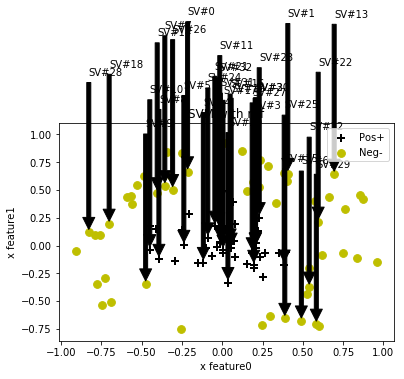

In [44]:
def test_rbf(k_sigma=1.3):
    X_train,y_train=loadDataset("testSetRBF.txt")
    X_train=np.mat(X_train)
    y_train=np.mat(y_train).transpose()
    b,alphas=smoPlatt(X_train,y_train,C=200,toler=0.0001,maxIter=110,kups=('rbf',k_sigma))
    X_train,y_train=loadDataset("testSetRBF.txt")
    Xvs=show_support_vectos(alphas,X_train,y_train)
    show_this_imag(X_train,y_train,Xvs,rbf_name="rbf")
    return Xvs,b,alphas
    
vs,b,alphas=test_rbf(1.3)

**总结**
其实这个迭代次数也不是很多的.


#####  预测
其实和其他的alphas无关,只和支持向量有关

In [45]:
def predict_rbf(vs,b,alphas):
    X_train,y_train=loadDataset("testSetRBF.txt")
    X_train=np.mat(X_train)
    y_train=np.mat(y_train).transpose()
    Xvs=X_train[vs]
    Yvs=y_train[vs]
    m,n=Xvs.shape
    error_cnt=0
    for i in range(m):
        kernelEval=kernelTrans(Xvs,X_train[i,:],('rbf',1.3))
        predict=kernelEval.T*np.multiply(Yvs,alphas[vs])+b #只和支持向量有关
        if np.sign(predict)!=np.sign(Yvs[i]):
            error_cnt+=1
    print("the trainning error rate:%f" %(float(error_cnt)/m))

    X_train,y_train=loadDataset("testSetRBF2.txt")
    X_train=np.mat(X_train)
    y_train=np.mat(y_train).transpose()

    error_cnt=0
    for i in range(m):
        kernelEval=kernelTrans(Xvs,X_train[i,:],('rbf',1.3))
        predict=kernelEval.T*np.multiply(Yvs,alphas[vs])+b #只和支持向量有关
        if np.sign(predict)!=np.sign(Yvs[i]):
            error_cnt+=1
    print("the test error rate:%f" %(float(error_cnt)/m))

    
predict_rbf(vs,b,alphas)

    


the trainning error rate:0.696970
the test error rate:0.484848
